## Model Selection

- We kept the categorical variables for easier visualization, but now we will encode them for modeling purposes. We look at all the categorical features and their number of unique values. For the ones with only two values, we can change those to a binary encoding. The ones with more than two values but not too many can be one-hot encoded. Finally, the ones with a lot of possible values and have some ordinal nature to them will be label encoded since we do not want to increase the dimensionality too much and risk negatively affecting our modeling process. 
- Now we will start looking at different models and their performances. Since this is a churn classification problem, the first instinct is to start with a basic logistic regression. We perform a grid search to fit the model for different combinations of hyperparameters and then evaluate them using cross-validation. 
- Next we perform hyperparamter tuning for Random Forest and XGBoost classifiers to identify the best hyperparameter combinations for each model.  
- We output the confusion matrices and classification reports for each of the top models. XGBoost looks to be peforming the best, performing slightly higher across the f1 score, precision, and recall. The random forest seems to also perform pretty well although slightly less than XGBoost. 
- Using our tuned XGBoost model, we plot our most important features. The top five:
    - `change_mou`: percentage change in monthly minutes of use vs previous three month average
    - `months`: total number of months in service
    - `eqpdays`: number of days (age) of current equipment
    - `mou_Mean`: mean number of monthly minutes of use
    - `change_rev`: percentage change in monthly revenue vs previous three month average
- We look at the two best performing models in XGBoost and Random Forest. Since they are different in their algorithms, training process, complexity, and interpretability, they are considered diverse models, and ensembling them could potentially lead to improved performance by leveraging their respective strengths. When we ensemble the models, there is a slight improvement in precision and recall scores, but nothing too significant. 
- We next try limiting our features to only the most important ones for the XGBoost model to see if a simpler model can provide a better result. It does not show any improvement, so we will proceed with our ensemble model. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/processed/modeling_data.csv')

In [15]:
df.head()

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,...,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID,num_ppl_household
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,-157.25,-18.9975,0.666667,...,N,U,U,U,U,U,Y,361.0,1000001,1
1,57.4925,482.75,37.425,0.2475,22.75,0.0,0.0,532.25,50.9875,8.333333,...,Z,U,U,U,U,U,Y,240.0,1000002,1
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,-4.25,0.0000,0.333333,...,N,U,Y,U,U,U,Y,1504.0,1000003,3
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,-1.50,0.0000,0.000000,...,U,Y,U,U,U,U,Y,1812.0,1000004,5
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,38.50,0.0000,9.666667,...,I,U,U,U,U,U,Y,434.0,1000005,1


In [3]:
# encoding cat vars

final_df = df.copy()

for i in final_df:
    if final_df[i].dtype == 'object':
        num_unique = len(final_df[i].value_counts(dropna=False))
        if num_unique == 2:
            unique_vals = list(final_df[i].unique())
            if 'Y' in unique_vals and 'N' in unique_vals:
                final_df[i] = final_df[i].replace({'N': 0, 'Y': 1})
            elif 'Y' in unique_vals and 'U' in unique_vals:
                final_df[i] = final_df[i].replace({'U': 0, 'Y': 1})
            elif 'N' in unique_vals and 'R' in unique_vals:
                final_df[i] = final_df[i].replace({'N': 0, 'R': 1})
            elif 'O' in unique_vals and 'R' in unique_vals:
                final_df[i] = final_df[i].replace({'R': 0, 'O': 1})
            elif 'S' in unique_vals and 'M' in unique_vals:
                final_df[i] = final_df[i].replace({'S': 0, 'M': 1})
            elif 'M' in unique_vals and 'N' in unique_vals:
                final_df[i] = final_df[i].replace({'N': 0, 'M': 1})
        elif num_unique < 20 and i != 'dwllsize':
            one_hot_encoded = pd.get_dummies(final_df[i], prefix=i).astype(int)
            final_df = pd.concat([final_df, one_hot_encoded], axis=1)
            final_df = final_df.drop(i, axis=1)

enc1 = LabelEncoder()
enc2 = LabelEncoder()

final_df['dwllsize'] = enc1.fit_transform(final_df['dwllsize'])
final_df['crclscod'] = enc2.fit_transform(final_df['crclscod'])

final_df.sort_values(by=['dwllsize', 'crclscod'], inplace=True)

final_df = final_df.drop(columns=['Customer_ID'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop('churn', axis=1), final_df['churn'], test_size=0.2, random_state=42)

In [82]:
# logistic regression 

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

test_score = best_model.score(X_test, y_test)

print('Best hyperparameters:', best_params)
print('Test set score:', test_score)

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Test set score: 0.59885


In [83]:
# random forest

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

test_score = best_model.score(X_test, y_test)

print('Best hyperparameters:', best_params)
print('Test set score:', test_score)

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Test set score: 0.6288


In [9]:
# xgboost

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb_clf = xgb.XGBClassifier()

grid_search = GridSearchCV(
    xgb_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, 
                y_train, 
                early_stopping_rounds=100,
                eval_metric='logloss', 
                eval_set=[(X_test, y_test)])

best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Best hyperparameters:', grid_search.best_params_)
print('Test set accuracy:', accuracy)

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[0]	validation_0-logloss:0.69255
[0]	validation_0-logloss:0.69255
[0]	validation_0-logloss:0.69255
[1]	validation_0-logloss:0.69207
[0]	validation_0-logloss:0.69256
[1]	validation_0-logloss:0.69206
[2]	validation_0-logloss:0.69159
[1]	validation_0-logloss:0.69206
[1]	validation_0-logloss:0.69207
[0]	validation_0-logloss:0.69256
[2]	validation_0-logloss:0.69158
[2]	validation_0-logloss:0.69159
[3]	validation_0-logloss:0.69112
[0]	validation_0-logloss:0.69255
[2]	validation_0-logloss:0.69159
[1]	validation_0-logloss:0.69207
[0]	validation_0-logloss:0.69255
[3]	validation_0-logloss:0.69111
[4]	validation_0-logloss:0.69066
[3]	validation_0-logloss:0.69111
[0]	validation_0-logloss:0.69255
[1]	validation_0-logloss:0.69207
[3]	validation_0-logloss:0.69112
[2]	validation_0-logloss:0.69159
[4]	validation_0-logloss:0.69065
[1]	validation_0-logloss:0.69206
[5]	validation_0-logloss:0.69021
[4]	validation_0-logloss:0.69066
[1]	validation_0-logloss:0.69206
[2]	validation_0-logloss:0.69159
[4]	valida

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[103]	validation_0-logloss:0.66883
[104]	validation_0-logloss:0.66849
[105]	validation_0-logloss:0.66842
[104]	validation_0-logloss:0.66871
[105]	validation_0-logloss:0.66838
[106]	validation_0-logloss:0.66832
[106]	validation_0-logloss:0.66828
[105]	validation_0-logloss:0.66861
[107]	validation_0-logloss:0.66821
[107]	validation_0-logloss:0.66817
[106]	validation_0-logloss:0.66850
[108]	validation_0-logloss:0.66809
[108]	validation_0-logloss:0.66806
[107]	validation_0-logloss:0.66839
[109]	validation_0-logloss:0.66799
[109]	validation_0-logloss:0.66795
[108]	validation_0-logloss:0.66829
[110]	validation_0-logloss:0.66787
[110]	validation_0-logloss:0.66785
[109]	validation_0-logloss:0.66818
[111]	validation_0-logloss:0.66777
[111]	validation_0-logloss:0.66775
[110]	validation_0-logloss:0.66809
[112]	validation_0-logloss:0.66766
[112]	validation_0-logloss:0.66764
[111]	validation_0-logloss:0.66798
[113]	validation_0-logloss:0.66755
[113]	validation_0-logloss:0.66754
[112]	validation_0-l

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[65]	validation_0-logloss:0.67412
[62]	validation_0-logloss:0.67436
[64]	validation_0-logloss:0.67434
[63]	validation_0-logloss:0.67423
[63]	validation_0-logloss:0.67424
[66]	validation_0-logloss:0.67398
[63]	validation_0-logloss:0.67419
[65]	validation_0-logloss:0.67417
[64]	validation_0-logloss:0.67404
[64]	validation_0-logloss:0.67409
[67]	validation_0-logloss:0.67380
[64]	validation_0-logloss:0.67401
[66]	validation_0-logloss:0.67401
[65]	validation_0-logloss:0.67389
[65]	validation_0-logloss:0.67391
[68]	validation_0-logloss:0.67364
[65]	validation_0-logloss:0.67385
[67]	validation_0-logloss:0.67384
[66]	validation_0-logloss:0.67371
[66]	validation_0-logloss:0.67374
[69]	validation_0-logloss:0.67350
[66]	validation_0-logloss:0.67371
[68]	validation_0-logloss:0.67370
[67]	validation_0-logloss:0.67356
[67]	validation_0-logloss:0.67360


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[70]	validation_0-logloss:0.67332
[67]	validation_0-logloss:0.67352
[69]	validation_0-logloss:0.67352
[68]	validation_0-logloss:0.67340
[68]	validation_0-logloss:0.67342
[71]	validation_0-logloss:0.67317
[68]	validation_0-logloss:0.67338
[70]	validation_0-logloss:0.67336
[69]	validation_0-logloss:0.67324
[69]	validation_0-logloss:0.67329
[72]	validation_0-logloss:0.67304
[69]	validation_0-logloss:0.67320
[71]	validation_0-logloss:0.67323
[70]	validation_0-logloss:0.67310
[70]	validation_0-logloss:0.67311
[73]	validation_0-logloss:0.67286
[70]	validation_0-logloss:0.67307
[72]	validation_0-logloss:0.67307
[71]	validation_0-logloss:0.67293
[71]	validation_0-logloss:0.67298
[74]	validation_0-logloss:0.67274
[71]	validation_0-logloss:0.67290
[73]	validation_0-logloss:0.67292
[72]	validation_0-logloss:0.67280
[72]	validation_0-logloss:0.67283
[75]	validation_0-logloss:0.67258
[72]	validation_0-logloss:0.67273
[74]	validation_0-logloss:0.67276
[73]	validation_0-logloss:0.67262
[73]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[199]	validation_0-logloss:0.66080
[201]	validation_0-logloss:0.66104
[100]	validation_0-logloss:0.66932
[102]	validation_0-logloss:0.66906
[203]	validation_0-logloss:0.66095
[200]	validation_0-logloss:0.66075
[84]	validation_0-logloss:0.66387
[202]	validation_0-logloss:0.66099
[101]	validation_0-logloss:0.66921
[103]	validation_0-logloss:0.66894
[201]	validation_0-logloss:0.66067
[204]	validation_0-logloss:0.66090
[203]	validation_0-logloss:0.66094
[85]	validation_0-logloss:0.66369
[102]	validation_0-logloss:0.66909
[104]	validation_0-logloss:0.66883
[202]	validation_0-logloss:0.66061
[205]	validation_0-logloss:0.66084
[204]	validation_0-logloss:0.66087
[103]	validation_0-logloss:0.66898
[86]	validation_0-logloss:0.66351
[105]	validation_0-logloss:0.66873
[203]	validation_0-logloss:0.66054
[206]	validation_0-logloss:0.66081
[205]	validation_0-logloss:0.66082
[104]	validation_0-logloss:0.66887
[87]	validation_0-logloss:0.66335
[106]	validation_0-logloss:0.66862
[207]	validation_0-loglo

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[125]	validation_0-logloss:0.66678
[228]	validation_0-logloss:0.65955
[226]	validation_0-logloss:0.65927
[128]	validation_0-logloss:0.66651
[230]	validation_0-logloss:0.65951
[229]	validation_0-logloss:0.65950
[126]	validation_0-logloss:0.66670
[227]	validation_0-logloss:0.65922
[129]	validation_0-logloss:0.66642
[231]	validation_0-logloss:0.65947
[230]	validation_0-logloss:0.65945
[228]	validation_0-logloss:0.65918
[127]	validation_0-logloss:0.66661
[130]	validation_0-logloss:0.66634
[232]	validation_0-logloss:0.65944
[229]	validation_0-logloss:0.65913
[231]	validation_0-logloss:0.65940
[128]	validation_0-logloss:0.66653
[131]	validation_0-logloss:0.66626
[233]	validation_0-logloss:0.65938
[230]	validation_0-logloss:0.65908
[232]	validation_0-logloss:0.65936
[129]	validation_0-logloss:0.66644
[132]	validation_0-logloss:0.66617
[234]	validation_0-logloss:0.65933
[233]	validation_0-logloss:0.65932
[231]	validation_0-logloss:0.65904
[0]	validation_0-logloss:0.69240
[130]	validation_0-log

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[198]	validation_0-logloss:0.66134
[37]	validation_0-logloss:0.67541
[57]	validation_0-logloss:0.66971
[59]	validation_0-logloss:0.66917
[203]	validation_0-logloss:0.66103
[199]	validation_0-logloss:0.66128
[38]	validation_0-logloss:0.67508
[58]	validation_0-logloss:0.66948
[204]	validation_0-logloss:0.66097
[60]	validation_0-logloss:0.66895
[200]	validation_0-logloss:0.66121
[39]	validation_0-logloss:0.67474
[205]	validation_0-logloss:0.66092
[59]	validation_0-logloss:0.66924
[201]	validation_0-logloss:0.66116
[61]	validation_0-logloss:0.66869


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[206]	validation_0-logloss:0.66086
[40]	validation_0-logloss:0.67442
[202]	validation_0-logloss:0.66110
[60]	validation_0-logloss:0.66900
[62]	validation_0-logloss:0.66847
[207]	validation_0-logloss:0.66080
[41]	validation_0-logloss:0.67410
[203]	validation_0-logloss:0.66105
[61]	validation_0-logloss:0.66877
[63]	validation_0-logloss:0.66821
[208]	validation_0-logloss:0.66074
[204]	validation_0-logloss:0.66100
[42]	validation_0-logloss:0.67380
[62]	validation_0-logloss:0.66854
[64]	validation_0-logloss:0.66798
[209]	validation_0-logloss:0.66068
[205]	validation_0-logloss:0.66095
[43]	validation_0-logloss:0.67349
[63]	validation_0-logloss:0.66832
[210]	validation_0-logloss:0.66062
[65]	validation_0-logloss:0.66776
[206]	validation_0-logloss:0.66089
[44]	validation_0-logloss:0.67319
[211]	validation_0-logloss:0.66057
[64]	validation_0-logloss:0.66811
[207]	validation_0-logloss:0.66083
[66]	validation_0-logloss:0.66753
[212]	validation_0-logloss:0.66052
[45]	validation_0-logloss:0.67291
[

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[252]	validation_0-logloss:0.65848
[20]	validation_0-logloss:0.68191
[17]	validation_0-logloss:0.68308
[257]	validation_0-logloss:0.65822
[20]	validation_0-logloss:0.68181
[82]	validation_0-logloss:0.66440
[253]	validation_0-logloss:0.65842
[21]	validation_0-logloss:0.68150
[18]	validation_0-logloss:0.68263
[258]	validation_0-logloss:0.65817
[21]	validation_0-logloss:0.68137
[254]	validation_0-logloss:0.65838
[83]	validation_0-logloss:0.66421
[259]	validation_0-logloss:0.65813
[22]	validation_0-logloss:0.68107
[19]	validation_0-logloss:0.68217
[255]	validation_0-logloss:0.65835
[22]	validation_0-logloss:0.68095
[260]	validation_0-logloss:0.65809
[84]	validation_0-logloss:0.66402
[23]	validation_0-logloss:0.68066
[20]	validation_0-logloss:0.68175
[256]	validation_0-logloss:0.65831
[23]	validation_0-logloss:0.68052
[261]	validation_0-logloss:0.65804
[85]	validation_0-logloss:0.66386
[257]	validation_0-logloss:0.65826
[24]	validation_0-logloss:0.68025
[21]	validation_0-logloss:0.68132
[26

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[43]	validation_0-logloss:0.67336
[280]	validation_0-logloss:0.65725
[285]	validation_0-logloss:0.65684
[41]	validation_0-logloss:0.67415
[44]	validation_0-logloss:0.67336
[281]	validation_0-logloss:0.65721
[286]	validation_0-logloss:0.65679
[44]	validation_0-logloss:0.67307
[42]	validation_0-logloss:0.67386
[45]	validation_0-logloss:0.67306
[282]	validation_0-logloss:0.65717
[287]	validation_0-logloss:0.65675
[45]	validation_0-logloss:0.67278
[43]	validation_0-logloss:0.67354
[0]	validation_0-logloss:0.69239
[46]	validation_0-logloss:0.67277
[283]	validation_0-logloss:0.65713
[288]	validation_0-logloss:0.65671
[46]	validation_0-logloss:0.67248
[44]	validation_0-logloss:0.67327
[1]	validation_0-logloss:0.69175
[284]	validation_0-logloss:0.65709
[47]	validation_0-logloss:0.67248
[289]	validation_0-logloss:0.65667
[47]	validation_0-logloss:0.67222
[45]	validation_0-logloss:0.67296
[2]	validation_0-logloss:0.69112
[285]	validation_0-logloss:0.65704
[290]	validation_0-logloss:0.65663
[0]	v

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[13]	validation_0-logloss:0.68506
[15]	validation_0-logloss:0.68405
[58]	validation_0-logloss:0.66945
[60]	validation_0-logloss:0.66874
[61]	validation_0-logloss:0.66901
[14]	validation_0-logloss:0.68457
[16]	validation_0-logloss:0.68358
[59]	validation_0-logloss:0.66917
[61]	validation_0-logloss:0.66851
[62]	validation_0-logloss:0.66879
[15]	validation_0-logloss:0.68408
[17]	validation_0-logloss:0.68312
[60]	validation_0-logloss:0.66895
[62]	validation_0-logloss:0.66828
[63]	validation_0-logloss:0.66856
[16]	validation_0-logloss:0.68362
[18]	validation_0-logloss:0.68264
[61]	validation_0-logloss:0.66869
[63]	validation_0-logloss:0.66803
[64]	validation_0-logloss:0.66834


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-logloss:0.68314
[19]	validation_0-logloss:0.68221
[62]	validation_0-logloss:0.66847
[64]	validation_0-logloss:0.66779
[65]	validation_0-logloss:0.66812
[18]	validation_0-logloss:0.68270
[20]	validation_0-logloss:0.68176
[63]	validation_0-logloss:0.66821
[65]	validation_0-logloss:0.66759
[66]	validation_0-logloss:0.66792
[19]	validation_0-logloss:0.68225
[21]	validation_0-logloss:0.68133
[64]	validation_0-logloss:0.66798
[66]	validation_0-logloss:0.66734
[67]	validation_0-logloss:0.66768
[20]	validation_0-logloss:0.68182
[22]	validation_0-logloss:0.68092
[65]	validation_0-logloss:0.66776
[67]	validation_0-logloss:0.66715
[68]	validation_0-logloss:0.66749
[0]	validation_0-logloss:0.69240
[21]	validation_0-logloss:0.68140
[23]	validation_0-logloss:0.68050
[66]	validation_0-logloss:0.66753
[68]	validation_0-logloss:0.66691
[69]	validation_0-logloss:0.66728
[22]	validation_0-logloss:0.68098
[1]	validation_0-logloss:0.69176
[24]	validation_0-logloss:0.68008
[67]	validation_

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[57]	validation_0-logloss:0.66969
[101]	validation_0-logloss:0.66093
[59]	validation_0-logloss:0.66924
[15]	validation_0-logloss:0.68402
[37]	validation_0-logloss:0.67550
[19]	validation_0-logloss:0.68225
[103]	validation_0-logloss:0.66083
[58]	validation_0-logloss:0.66947
[102]	validation_0-logloss:0.66075
[60]	validation_0-logloss:0.66900
[16]	validation_0-logloss:0.68355
[38]	validation_0-logloss:0.67517
[20]	validation_0-logloss:0.68181
[104]	validation_0-logloss:0.66071
[103]	validation_0-logloss:0.66061
[59]	validation_0-logloss:0.66924
[61]	validation_0-logloss:0.66877
[17]	validation_0-logloss:0.68308
[39]	validation_0-logloss:0.67485
[21]	validation_0-logloss:0.68137
[105]	validation_0-logloss:0.66056
[60]	validation_0-logloss:0.66900
[104]	validation_0-logloss:0.66048
[18]	validation_0-logloss:0.68263
[40]	validation_0-logloss:0.67456
[62]	validation_0-logloss:0.66854
[22]	validation_0-logloss:0.68095
[106]	validation_0-logloss:0.66042
[105]	validation_0-logloss:0.66030
[61]	

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[157]	validation_0-logloss:0.65494
[112]	validation_0-logloss:0.65932
[155]	validation_0-logloss:0.65523
[115]	validation_0-logloss:0.65925
[136]	validation_0-logloss:0.65732
[74]	validation_0-logloss:0.66604
[158]	validation_0-logloss:0.65485
[156]	validation_0-logloss:0.65512
[113]	validation_0-logloss:0.65917
[116]	validation_0-logloss:0.65912
[137]	validation_0-logloss:0.65722
[159]	validation_0-logloss:0.65476
[75]	validation_0-logloss:0.66583
[157]	validation_0-logloss:0.65502
[117]	validation_0-logloss:0.65899
[114]	validation_0-logloss:0.65903
[138]	validation_0-logloss:0.65709
[160]	validation_0-logloss:0.65467
[76]	validation_0-logloss:0.66561
[118]	validation_0-logloss:0.65888
[158]	validation_0-logloss:0.65496
[115]	validation_0-logloss:0.65891
[139]	validation_0-logloss:0.65697
[161]	validation_0-logloss:0.65458
[77]	validation_0-logloss:0.66543
[116]	validation_0-logloss:0.65879
[159]	validation_0-logloss:0.65487
[119]	validation_0-logloss:0.65876
[140]	validation_0-loglo

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



[118]	validation_0-logloss:0.65917
[18]	validation_0-logloss:0.68280
[158]	validation_0-logloss:0.65416
[19]	validation_0-logloss:0.68225
[183]	validation_0-logloss:0.65287
[162]	validation_0-logloss:0.65422
[119]	validation_0-logloss:0.65904
[19]	validation_0-logloss:0.68235
[159]	validation_0-logloss:0.65406
[20]	validation_0-logloss:0.68182
[184]	validation_0-logloss:0.65278
[163]	validation_0-logloss:0.65410
[120]	validation_0-logloss:0.65891
[20]	validation_0-logloss:0.68191
[160]	validation_0-logloss:0.65397
[21]	validation_0-logloss:0.68140
[185]	validation_0-logloss:0.65272
[164]	validation_0-logloss:0.65402


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[121]	validation_0-logloss:0.65878
[21]	validation_0-logloss:0.68150
[161]	validation_0-logloss:0.65387
[22]	validation_0-logloss:0.68098
[186]	validation_0-logloss:0.65265
[165]	validation_0-logloss:0.65391
[122]	validation_0-logloss:0.65867
[162]	validation_0-logloss:0.65379
[22]	validation_0-logloss:0.68107
[187]	validation_0-logloss:0.65259
[23]	validation_0-logloss:0.68057
[166]	validation_0-logloss:0.65384
[123]	validation_0-logloss:0.65855
[163]	validation_0-logloss:0.65369
[23]	validation_0-logloss:0.68066
[188]	validation_0-logloss:0.65250
[24]	validation_0-logloss:0.68016
[167]	validation_0-logloss:0.65374
[124]	validation_0-logloss:0.65842
[164]	validation_0-logloss:0.65360
[189]	validation_0-logloss:0.65244
[24]	validation_0-logloss:0.68025
[25]	validation_0-logloss:0.67976
[168]	validation_0-logloss:0.65365
[125]	validation_0-logloss:0.65829
[165]	validation_0-logloss:0.65351
[190]	validation_0-logloss:0.65235
[25]	validation_0-logloss:0.67984
[26]	validation_0-logloss:0.6

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[179]	validation_0-logloss:0.65232
[39]	validation_0-logloss:0.67474
[139]	validation_0-logloss:0.65669
[38]	validation_0-logloss:0.67517
[183]	validation_0-logloss:0.65229
[180]	validation_0-logloss:0.65224
[40]	validation_0-logloss:0.67442
[140]	validation_0-logloss:0.65659
[39]	validation_0-logloss:0.67485
[184]	validation_0-logloss:0.65221
[181]	validation_0-logloss:0.65216
[141]	validation_0-logloss:0.65649
[41]	validation_0-logloss:0.67410
[185]	validation_0-logloss:0.65210
[40]	validation_0-logloss:0.67456
[182]	validation_0-logloss:0.65209
[142]	validation_0-logloss:0.65638
[186]	validation_0-logloss:0.65202
[42]	validation_0-logloss:0.67380
[41]	validation_0-logloss:0.67425
[183]	validation_0-logloss:0.65201
[143]	validation_0-logloss:0.65628
[187]	validation_0-logloss:0.65194
[43]	validation_0-logloss:0.67349
[42]	validation_0-logloss:0.67394
[184]	validation_0-logloss:0.65192
[144]	validation_0-logloss:0.65617
[188]	validation_0-logloss:0.65186
[44]	validation_0-logloss:0.67

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-logloss:0.65900
[152]	validation_0-logloss:0.65567
[154]	validation_0-logloss:0.65530
[261]	validation_0-logloss:0.64797
[82]	validation_0-logloss:0.65922
[68]	validation_0-logloss:0.66304
[153]	validation_0-logloss:0.65559
[155]	validation_0-logloss:0.65523
[84]	validation_0-logloss:0.65877
[262]	validation_0-logloss:0.64789
[154]	validation_0-logloss:0.65547
[83]	validation_0-logloss:0.65901
[69]	validation_0-logloss:0.66280
[156]	validation_0-logloss:0.65512
[263]	validation_0-logloss:0.64784
[85]	validation_0-logloss:0.65857
[155]	validation_0-logloss:0.65538


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[157]	validation_0-logloss:0.65502
[264]	validation_0-logloss:0.64778
[84]	validation_0-logloss:0.65876
[70]	validation_0-logloss:0.66252
[156]	validation_0-logloss:0.65527
[86]	validation_0-logloss:0.65835
[265]	validation_0-logloss:0.64771
[158]	validation_0-logloss:0.65496
[85]	validation_0-logloss:0.65853
[71]	validation_0-logloss:0.66225
[157]	validation_0-logloss:0.65517
[266]	validation_0-logloss:0.64765
[87]	validation_0-logloss:0.65813
[159]	validation_0-logloss:0.65487
[158]	validation_0-logloss:0.65507
[86]	validation_0-logloss:0.65831
[267]	validation_0-logloss:0.64761
[72]	validation_0-logloss:0.66201
[160]	validation_0-logloss:0.65480
[88]	validation_0-logloss:0.65792
[159]	validation_0-logloss:0.65496
[268]	validation_0-logloss:0.64757
[87]	validation_0-logloss:0.65814
[161]	validation_0-logloss:0.65472
[73]	validation_0-logloss:0.66177
[160]	validation_0-logloss:0.65488
[89]	validation_0-logloss:0.65773
[269]	validation_0-logloss:0.64752
[162]	validation_0-logloss:0.654

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[289]	validation_0-logloss:0.64657
[180]	validation_0-logloss:0.65310
[182]	validation_0-logloss:0.65281
[88]	validation_0-logloss:0.65851
[1]	validation_0-logloss:0.69156
[290]	validation_0-logloss:0.64653
[181]	validation_0-logloss:0.65301
[183]	validation_0-logloss:0.65273
[291]	validation_0-logloss:0.64647
[2]	validation_0-logloss:0.69083[182]	validation_0-logloss:0.65294

[89]	validation_0-logloss:0.65833
[184]	validation_0-logloss:0.65261
[292]	validation_0-logloss:0.64643
[183]	validation_0-logloss:0.65287
[0]	validation_0-logloss:0.69230
[185]	validation_0-logloss:0.65251
[3]	validation_0-logloss:0.69013
[90]	validation_0-logloss:0.65812
[293]	validation_0-logloss:0.64637
[184]	validation_0-logloss:0.65278
[186]	validation_0-logloss:0.65245
[1]	validation_0-logloss:0.69156
[91]	validation_0-logloss:0.65793
[294]	validation_0-logloss:0.64632
[4]	validation_0-logloss:0.68943
[185]	validation_0-logloss:0.65272
[187]	validation_0-logloss:0.65232
[295]	validation_0-logloss:0.64628
[

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-logloss:0.68497
[195]	validation_0-logloss:0.65202
[197]	validation_0-logloss:0.65153
[9]	validation_0-logloss:0.68623
[196]	validation_0-logloss:0.65196
[198]	validation_0-logloss:0.65146
[99]	validation_0-logloss:0.65650
[12]	validation_0-logloss:0.68437
[10]	validation_0-logloss:0.68561
[197]	validation_0-logloss:0.65190
[199]	validation_0-logloss:0.65136
[13]	validation_0-logloss:0.68379
[200]	validation_0-logloss:0.65130
[198]	validation_0-logloss:0.65184
[11]	validation_0-logloss:0.68501
[201]	validation_0-logloss:0.65123
[199]	validation_0-logloss:0.65176
[14]	validation_0-logloss:0.68321
[12]	validation_0-logloss:0.68443
[202]	validation_0-logloss:0.65114
[200]	validation_0-logloss:0.65169
[15]	validation_0-logloss:0.68264


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[203]	validation_0-logloss:0.65108
[201]	validation_0-logloss:0.65161
[13]	validation_0-logloss:0.68385
[16]	validation_0-logloss:0.68208
[204]	validation_0-logloss:0.65100
[202]	validation_0-logloss:0.65154
[14]	validation_0-logloss:0.68327
[205]	validation_0-logloss:0.65092
[203]	validation_0-logloss:0.65149
[17]	validation_0-logloss:0.68154
[15]	validation_0-logloss:0.68272
[206]	validation_0-logloss:0.65083
[204]	validation_0-logloss:0.65143
[18]	validation_0-logloss:0.68098
[205]	validation_0-logloss:0.65135
[207]	validation_0-logloss:0.65077
[16]	validation_0-logloss:0.68217
[19]	validation_0-logloss:0.68046
[208]	validation_0-logloss:0.65071
[206]	validation_0-logloss:0.65129
[17]	validation_0-logloss:0.68162
[209]	validation_0-logloss:0.65065
[207]	validation_0-logloss:0.65124
[20]	validation_0-logloss:0.67995
[0]	validation_0-logloss:0.69231
[210]	validation_0-logloss:0.65060
[208]	validation_0-logloss:0.65117
[18]	validation_0-logloss:0.68105
[21]	validation_0-logloss:0.67944

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-logloss:0.66256
[88]	validation_0-logloss:0.65826
[57]	validation_0-logloss:0.66595
[87]	validation_0-logloss:0.65872
[65]	validation_0-logloss:0.66327
[53]	validation_0-logloss:0.66687
[69]	validation_0-logloss:0.66228
[89]	validation_0-logloss:0.65809
[58]	validation_0-logloss:0.66568
[88]	validation_0-logloss:0.65851
[66]	validation_0-logloss:0.66300
[54]	validation_0-logloss:0.66658
[70]	validation_0-logloss:0.66206
[90]	validation_0-logloss:0.65786
[59]	validation_0-logloss:0.66539
[89]	validation_0-logloss:0.65829


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[55]	validation_0-logloss:0.66626
[67]	validation_0-logloss:0.66273
[71]	validation_0-logloss:0.66179
[60]	validation_0-logloss:0.66512
[91]	validation_0-logloss:0.65768
[90]	validation_0-logloss:0.65808
[56]	validation_0-logloss:0.66597
[68]	validation_0-logloss:0.66249
[72]	validation_0-logloss:0.66154
[61]	validation_0-logloss:0.66483
[92]	validation_0-logloss:0.65749
[91]	validation_0-logloss:0.65788
[57]	validation_0-logloss:0.66568
[69]	validation_0-logloss:0.66222
[73]	validation_0-logloss:0.66127
[62]	validation_0-logloss:0.66456
[93]	validation_0-logloss:0.65733
[92]	validation_0-logloss:0.65771
[58]	validation_0-logloss:0.66539
[70]	validation_0-logloss:0.66196
[74]	validation_0-logloss:0.66105
[63]	validation_0-logloss:0.66431
[94]	validation_0-logloss:0.65711
[93]	validation_0-logloss:0.65753
[59]	validation_0-logloss:0.66511
[71]	validation_0-logloss:0.66170
[75]	validation_0-logloss:0.66080
[64]	validation_0-logloss:0.66404
[94]	validation_0-logloss:0.65734
[95]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-logloss:0.66302
[72]	validation_0-logloss:0.66201
[83]	validation_0-logloss:0.65901
[79]	validation_0-logloss:0.65985


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-logloss:0.66275
[73]	validation_0-logloss:0.66177
[84]	validation_0-logloss:0.65876
[80]	validation_0-logloss:0.65962
[69]	validation_0-logloss:0.66249
[74]	validation_0-logloss:0.66151
[85]	validation_0-logloss:0.65853
[81]	validation_0-logloss:0.65943
[70]	validation_0-logloss:0.66227
[75]	validation_0-logloss:0.66129
[86]	validation_0-logloss:0.65831
[82]	validation_0-logloss:0.65920
[71]	validation_0-logloss:0.66201
[76]	validation_0-logloss:0.66105
[87]	validation_0-logloss:0.65814
[83]	validation_0-logloss:0.65900
[72]	validation_0-logloss:0.66176
[77]	validation_0-logloss:0.66082
[88]	validation_0-logloss:0.65793
[0]	validation_0-logloss:0.69230
[84]	validation_0-logloss:0.65877
[73]	validation_0-logloss:0.66151
[78]	validation_0-logloss:0.66060
[89]	validation_0-logloss:0.65772
[1]	validation_0-logloss:0.69156
[85]	validation_0-logloss:0.65857
[74]	validation_0-logloss:0.66126
[79]	validation_0-logloss:0.66038
[90]	validation_0-logloss:0.65752
[2]	validation_0

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[196]	validation_0-logloss:0.64531
[107]	validation_0-logloss:0.65515
[120]	validation_0-logloss:0.65275
[123]	validation_0-logloss:0.65269


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[110]	validation_0-logloss:0.65407
[197]	validation_0-logloss:0.64522
[108]	validation_0-logloss:0.65497
[121]	validation_0-logloss:0.65262
[124]	validation_0-logloss:0.65253
[111]	validation_0-logloss:0.65392
[198]	validation_0-logloss:0.64517
[122]	validation_0-logloss:0.65251
[109]	validation_0-logloss:0.65481
[125]	validation_0-logloss:0.65240
[112]	validation_0-logloss:0.65376
[199]	validation_0-logloss:0.64507
[123]	validation_0-logloss:0.65237
[110]	validation_0-logloss:0.65467
[126]	validation_0-logloss:0.65226
[113]	validation_0-logloss:0.65363
[124]	validation_0-logloss:0.65225
[111]	validation_0-logloss:0.65449
[127]	validation_0-logloss:0.65212
[114]	validation_0-logloss:0.65348
[125]	validation_0-logloss:0.65213
[112]	validation_0-logloss:0.65432
[128]	validation_0-logloss:0.65198
[115]	validation_0-logloss:0.65337
[113]	validation_0-logloss:0.65417
[126]	validation_0-logloss:0.65200
[129]	validation_0-logloss:0.65185
[116]	validation_0-logloss:0.65322
[127]	validation_0-l

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[115]	validation_0-logloss:0.65388
[128]	validation_0-logloss:0.65174
[131]	validation_0-logloss:0.65160
[118]	validation_0-logloss:0.65294
[116]	validation_0-logloss:0.65373
[129]	validation_0-logloss:0.65159
[132]	validation_0-logloss:0.65146
[119]	validation_0-logloss:0.65283
[130]	validation_0-logloss:0.65145
[117]	validation_0-logloss:0.65358
[133]	validation_0-logloss:0.65134
[120]	validation_0-logloss:0.65270
[131]	validation_0-logloss:0.65136
[134]	validation_0-logloss:0.65120
[118]	validation_0-logloss:0.65343
[121]	validation_0-logloss:0.65256
[119]	validation_0-logloss:0.65329
[132]	validation_0-logloss:0.65124
[135]	validation_0-logloss:0.65111
[122]	validation_0-logloss:0.65242
[120]	validation_0-logloss:0.65316
[133]	validation_0-logloss:0.65114
[136]	validation_0-logloss:0.65101
[123]	validation_0-logloss:0.65229
[121]	validation_0-logloss:0.65299
[134]	validation_0-logloss:0.65104
[137]	validation_0-logloss:0.65089
[124]	validation_0-logloss:0.65214
[135]	validation_0-l

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[61]	validation_0-logloss:0.66479
[52]	validation_0-logloss:0.66719
[97]	validation_0-logloss:0.64219
[204]	validation_0-logloss:0.64430
[193]	validation_0-logloss:0.64522
[88]	validation_0-logloss:0.64288
[190]	validation_0-logloss:0.64571
[98]	validation_0-logloss:0.64211
[62]	validation_0-logloss:0.66453
[53]	validation_0-logloss:0.66687
[89]	validation_0-logloss:0.64280
[205]	validation_0-logloss:0.64424
[99]	validation_0-logloss:0.64210
[194]	validation_0-logloss:0.64515
[191]	validation_0-logloss:0.64563
[90]	validation_0-logloss:0.64274
[63]	validation_0-logloss:0.66427
[206]	validation_0-logloss:0.64413
[54]	validation_0-logloss:0.66658
[91]	validation_0-logloss:0.64263
[192]	validation_0-logloss:0.64554
[195]	validation_0-logloss:0.64507
[207]	validation_0-logloss:0.64405
[92]	validation_0-logloss:0.64257
[64]	validation_0-logloss:0.66400
[55]	validation_0-logloss:0.66626
[196]	validation_0-logloss:0.64499
[193]	validation_0-logloss:0.64549
[93]	validation_0-logloss:0.64253


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[208]	validation_0-logloss:0.64399
[94]	validation_0-logloss:0.64241
[194]	validation_0-logloss:0.64541
[56]	validation_0-logloss:0.66597
[65]	validation_0-logloss:0.66373
[197]	validation_0-logloss:0.64490
[95]	validation_0-logloss:0.64228
[209]	validation_0-logloss:0.64392
[195]	validation_0-logloss:0.64536
[198]	validation_0-logloss:0.64483
[66]	validation_0-logloss:0.66348
[57]	validation_0-logloss:0.66568
[96]	validation_0-logloss:0.64212
[210]	validation_0-logloss:0.64382
[196]	validation_0-logloss:0.64532
[97]	validation_0-logloss:0.64194
[199]	validation_0-logloss:0.64476
[67]	validation_0-logloss:0.66324
[58]	validation_0-logloss:0.66539
[98]	validation_0-logloss:0.64188
[211]	validation_0-logloss:0.64375
[197]	validation_0-logloss:0.64524
[200]	validation_0-logloss:0.64469
[99]	validation_0-logloss:0.64178
[59]	validation_0-logloss:0.66511
[68]	validation_0-logloss:0.66299
[212]	validation_0-logloss:0.64368
[198]	validation_0-logloss:0.64518
[201]	validation_0-logloss:0.64460

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-logloss:0.66222
[62]	validation_0-logloss:0.66428
[215]	validation_0-logloss:0.64347
[201]	validation_0-logloss:0.64498
[204]	validation_0-logloss:0.64438
[216]	validation_0-logloss:0.64339
[72]	validation_0-logloss:0.66198
[63]	validation_0-logloss:0.66401
[202]	validation_0-logloss:0.64493
[205]	validation_0-logloss:0.64433
[217]	validation_0-logloss:0.64334
[203]	validation_0-logloss:0.64483
[206]	validation_0-logloss:0.64423
[73]	validation_0-logloss:0.66174
[64]	validation_0-logloss:0.66374
[218]	validation_0-logloss:0.64323
[204]	validation_0-logloss:0.64479
[207]	validation_0-logloss:0.64417
[74]	validation_0-logloss:0.66150
[65]	validation_0-logloss:0.66349
[219]	validation_0-logloss:0.64317
[205]	validation_0-logloss:0.64470
[208]	validation_0-logloss:0.64410
[75]	validation_0-logloss:0.66127
[66]	validation_0-logloss:0.66326
[220]	validation_0-logloss:0.64309
[206]	validation_0-logloss:0.64464
[209]	validation_0-logloss:0.64405
[76]	validation_0-logloss:0.66

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[85]	validation_0-logloss:0.64331
[96]	validation_0-logloss:0.64245
[133]	validation_0-logloss:0.65140
[284]	validation_0-logloss:0.63994
[294]	validation_0-logloss:0.63927
[281]	validation_0-logloss:0.64058
[86]	validation_0-logloss:0.64322
[97]	validation_0-logloss:0.64243
[144]	validation_0-logloss:0.65018
[87]	validation_0-logloss:0.64310
[285]	validation_0-logloss:0.63989
[98]	validation_0-logloss:0.64228
[134]	validation_0-logloss:0.65128
[295]	validation_0-logloss:0.63923
[282]	validation_0-logloss:0.64054
[145]	validation_0-logloss:0.65008
[88]	validation_0-logloss:0.64303
[99]	validation_0-logloss:0.64215
[296]	validation_0-logloss:0.63920
[286]	validation_0-logloss:0.63983
[135]	validation_0-logloss:0.65117
[283]	validation_0-logloss:0.64052
[89]	validation_0-logloss:0.64301
[146]	validation_0-logloss:0.64998
[90]	validation_0-logloss:0.64292
[287]	validation_0-logloss:0.63980
[297]	validation_0-logloss:0.63916
[284]	validation_0-logloss:0.64046
[136]	validation_0-logloss:0.6

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[287]	validation_0-logloss:0.64034
[95]	validation_0-logloss:0.64230
[139]	validation_0-logloss:0.65071
[150]	validation_0-logloss:0.64961
[291]	validation_0-logloss:0.63965
[96]	validation_0-logloss:0.64215
[288]	validation_0-logloss:0.64029
[140]	validation_0-logloss:0.65058
[97]	validation_0-logloss:0.64202
[151]	validation_0-logloss:0.64951
[292]	validation_0-logloss:0.63962
[289]	validation_0-logloss:0.64026
[98]	validation_0-logloss:0.64197
[141]	validation_0-logloss:0.65048
[152]	validation_0-logloss:0.64943
[99]	validation_0-logloss:0.64191
[293]	validation_0-logloss:0.63960
[290]	validation_0-logloss:0.64020
[142]	validation_0-logloss:0.65037
[153]	validation_0-logloss:0.64932
[294]	validation_0-logloss:0.63956
[291]	validation_0-logloss:0.64017
[143]	validation_0-logloss:0.65028
[295]	validation_0-logloss:0.63954
[154]	validation_0-logloss:0.64923
[292]	validation_0-logloss:0.64014


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[144]	validation_0-logloss:0.65015
[296]	validation_0-logloss:0.63952
[155]	validation_0-logloss:0.64913
[293]	validation_0-logloss:0.64008
[297]	validation_0-logloss:0.63946
[145]	validation_0-logloss:0.65003
[294]	validation_0-logloss:0.64005
[156]	validation_0-logloss:0.64903
[298]	validation_0-logloss:0.63942
[146]	validation_0-logloss:0.64992
[295]	validation_0-logloss:0.64002
[157]	validation_0-logloss:0.64894
[299]	validation_0-logloss:0.63937
[296]	validation_0-logloss:0.63997
[147]	validation_0-logloss:0.64981
[158]	validation_0-logloss:0.64883
[297]	validation_0-logloss:0.63994
[148]	validation_0-logloss:0.64972
[159]	validation_0-logloss:0.64875
[298]	validation_0-logloss:0.63991
[160]	validation_0-logloss:0.64866
[149]	validation_0-logloss:0.64962
[299]	validation_0-logloss:0.63987
[161]	validation_0-logloss:0.64856
[150]	validation_0-logloss:0.64951
[162]	validation_0-logloss:0.64847
[151]	validation_0-logloss:0.64942
[163]	validation_0-logloss:0.64838
[152]	validation_0-l

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[164]	validation_0-logloss:0.64829
[0]	validation_0-logloss:0.68829
[153]	validation_0-logloss:0.64924
[1]	validation_0-logloss:0.68442
[165]	validation_0-logloss:0.64820
[154]	validation_0-logloss:0.64915
[2]	validation_0-logloss:0.68126
[3]	validation_0-logloss:0.67870
[166]	validation_0-logloss:0.64812
[155]	validation_0-logloss:0.64904
[4]	validation_0-logloss:0.67641


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[167]	validation_0-logloss:0.64804
[156]	validation_0-logloss:0.64896
[5]	validation_0-logloss:0.67444
[6]	validation_0-logloss:0.67273
[168]	validation_0-logloss:0.64794
[157]	validation_0-logloss:0.64888
[7]	validation_0-logloss:0.67132
[169]	validation_0-logloss:0.64787
[158]	validation_0-logloss:0.64879
[8]	validation_0-logloss:0.66993
[0]	validation_0-logloss:0.68827
[9]	validation_0-logloss:0.66878
[170]	validation_0-logloss:0.64778
[159]	validation_0-logloss:0.64869
[1]	validation_0-logloss:0.68438
[10]	validation_0-logloss:0.66781
[2]	validation_0-logloss:0.68150
[171]	validation_0-logloss:0.64769
[11]	validation_0-logloss:0.66686
[160]	validation_0-logloss:0.64860
[3]	validation_0-logloss:0.67856
[12]	validation_0-logloss:0.66592
[172]	validation_0-logloss:0.64762
[4]	validation_0-logloss:0.67646
[161]	validation_0-logloss:0.64851
[13]	validation_0-logloss:0.66507
[5]	validation_0-logloss:0.67451
[173]	validation_0-logloss:0.64754
[14]	validation_0-logloss:0.66422
[162]	valida

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[197]	validation_0-logloss:0.63645
[170]	validation_0-logloss:0.63732
[298]	validation_0-logloss:0.63974
[176]	validation_0-logloss:0.63749
[181]	validation_0-logloss:0.63766
[286]	validation_0-logloss:0.63994
[188]	validation_0-logloss:0.63711
[198]	validation_0-logloss:0.63638
[171]	validation_0-logloss:0.63732
[177]	validation_0-logloss:0.63742
[189]	validation_0-logloss:0.63709
[182]	validation_0-logloss:0.63763
[199]	validation_0-logloss:0.63634
[299]	validation_0-logloss:0.63971
[287]	validation_0-logloss:0.63988
[172]	validation_0-logloss:0.63726
[178]	validation_0-logloss:0.63739
[190]	validation_0-logloss:0.63700
[183]	validation_0-logloss:0.63759
[173]	validation_0-logloss:0.63726
[191]	validation_0-logloss:0.63698
[179]	validation_0-logloss:0.63738
[288]	validation_0-logloss:0.63985
[184]	validation_0-logloss:0.63752
[174]	validation_0-logloss:0.63717
[192]	validation_0-logloss:0.63694
[180]	validation_0-logloss:0.63725
[185]	validation_0-logloss:0.63748
[289]	validation_0-l

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[184]	validation_0-logloss:0.63703
[189]	validation_0-logloss:0.63732
[197]	validation_0-logloss:0.63680
[179]	validation_0-logloss:0.63694
[292]	validation_0-logloss:0.63966
[185]	validation_0-logloss:0.63702
[190]	validation_0-logloss:0.63734
[198]	validation_0-logloss:0.63678
[180]	validation_0-logloss:0.63688


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[186]	validation_0-logloss:0.63701
[293]	validation_0-logloss:0.63962
[191]	validation_0-logloss:0.63726
[199]	validation_0-logloss:0.63674
[187]	validation_0-logloss:0.63697
[181]	validation_0-logloss:0.63684
[192]	validation_0-logloss:0.63720
[294]	validation_0-logloss:0.63958
[188]	validation_0-logloss:0.63698
[182]	validation_0-logloss:0.63675
[193]	validation_0-logloss:0.63721
[183]	validation_0-logloss:0.63675
[189]	validation_0-logloss:0.63690
[295]	validation_0-logloss:0.63954
[194]	validation_0-logloss:0.63717
[184]	validation_0-logloss:0.63668
[190]	validation_0-logloss:0.63686
[195]	validation_0-logloss:0.63714
[296]	validation_0-logloss:0.63951
[191]	validation_0-logloss:0.63685
[185]	validation_0-logloss:0.63659
[196]	validation_0-logloss:0.63708
[192]	validation_0-logloss:0.63683
[186]	validation_0-logloss:0.63661
[297]	validation_0-logloss:0.63948
[197]	validation_0-logloss:0.63704
[193]	validation_0-logloss:0.63678


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[187]	validation_0-logloss:0.63662
[298]	validation_0-logloss:0.63944
[198]	validation_0-logloss:0.63703
[194]	validation_0-logloss:0.63676
[188]	validation_0-logloss:0.63660
[199]	validation_0-logloss:0.63697
[195]	validation_0-logloss:0.63674
[189]	validation_0-logloss:0.63656
[299]	validation_0-logloss:0.63939
[196]	validation_0-logloss:0.63672
[190]	validation_0-logloss:0.63651
[197]	validation_0-logloss:0.63671
[191]	validation_0-logloss:0.63649
[198]	validation_0-logloss:0.63667
[192]	validation_0-logloss:0.63646
[199]	validation_0-logloss:0.63661
[193]	validation_0-logloss:0.63645
[194]	validation_0-logloss:0.63639
[195]	validation_0-logloss:0.63640
[196]	validation_0-logloss:0.63639
[197]	validation_0-logloss:0.63632


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[198]	validation_0-logloss:0.63628
[199]	validation_0-logloss:0.63630
[200]	validation_0-logloss:0.63632
[201]	validation_0-logloss:0.63630
[202]	validation_0-logloss:0.63628
[0]	validation_0-logloss:0.68827
[203]	validation_0-logloss:0.63629
[1]	validation_0-logloss:0.68438
[204]	validation_0-logloss:0.63628
[2]	validation_0-logloss:0.68150
[205]	validation_0-logloss:0.63617
[3]	validation_0-logloss:0.67856
[206]	validation_0-logloss:0.63617
[4]	validation_0-logloss:0.67646
[207]	validation_0-logloss:0.63613
[5]	validation_0-logloss:0.67451
[208]	validation_0-logloss:0.63602
[6]	validation_0-logloss:0.67266
[209]	validation_0-logloss:0.63601
[7]	validation_0-logloss:0.67140
[210]	validation_0-logloss:0.63601
[0]	validation_0-logloss:0.68827
[8]	validation_0-logloss:0.66991
[211]	validation_0-logloss:0.63596
[1]	validation_0-logloss:0.68436
[212]	validation_0-logloss:0.63591
[9]	validation_0-logloss:0.66869
[2]	validation_0-logloss:0.68120
[0]	validation_0-logloss:0.68830
[213]	validat

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[226]	validation_0-logloss:0.63566
[14]	validation_0-logloss:0.66402
[22]	validation_0-logloss:0.65887
[6]	validation_0-logloss:0.67317
[13]	validation_0-logloss:0.66522
[15]	validation_0-logloss:0.66329
[227]	validation_0-logloss:0.63564
[23]	validation_0-logloss:0.65840
[14]	validation_0-logloss:0.66432
[7]	validation_0-logloss:0.67165
[16]	validation_0-logloss:0.66262
[228]	validation_0-logloss:0.63561
[24]	validation_0-logloss:0.65794
[15]	validation_0-logloss:0.66357
[8]	validation_0-logloss:0.67019
[229]	validation_0-logloss:0.63559
[17]	validation_0-logloss:0.66184
[25]	validation_0-logloss:0.65756
[9]	validation_0-logloss:0.66901
[16]	validation_0-logloss:0.66287
[230]	validation_0-logloss:0.63551
[18]	validation_0-logloss:0.66125
[26]	validation_0-logloss:0.65698
[231]	validation_0-logloss:0.63550
[17]	validation_0-logloss:0.66218
[10]	validation_0-logloss:0.66796
[19]	validation_0-logloss:0.66068
[0]	validation_0-logloss:0.68697
[27]	validation_0-logloss:0.65655
[232]	validat

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-logloss:0.64314
[62]	validation_0-logloss:0.63683
[91]	validation_0-logloss:0.64291
[39]	validation_0-logloss:0.64236
[84]	validation_0-logloss:0.64336
[100]	validation_0-logloss:0.64174
[61]	validation_0-logloss:0.63739
[93]	validation_0-logloss:0.64311
[92]	validation_0-logloss:0.64288
[63]	validation_0-logloss:0.63679
[40]	validation_0-logloss:0.64217
[85]	validation_0-logloss:0.64331
[101]	validation_0-logloss:0.64166
[62]	validation_0-logloss:0.63729
[94]	validation_0-logloss:0.64293
[93]	validation_0-logloss:0.64266
[64]	validation_0-logloss:0.63672
[86]	validation_0-logloss:0.64322
[102]	validation_0-logloss:0.64160
[41]	validation_0-logloss:0.64177
[95]	validation_0-logloss:0.64282
[63]	validation_0-logloss:0.63712
[94]	validation_0-logloss:0.64257
[87]	validation_0-logloss:0.64310
[103]	validation_0-logloss:0.64148
[65]	validation_0-logloss:0.63652
[42]	validation_0-logloss:0.64145
[96]	validation_0-logloss:0.64269
[64]	validation_0-logloss:0.63697
[95]	valid

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[80]	validation_0-logloss:0.63542
[139]	validation_0-logloss:0.63929
[147]	validation_0-logloss:0.63871
[140]	validation_0-logloss:0.63950
[14]	validation_0-logloss:0.65529
[132]	validation_0-logloss:0.63939
[81]	validation_0-logloss:0.63540
[140]	validation_0-logloss:0.63922
[148]	validation_0-logloss:0.63868
[141]	validation_0-logloss:0.63944
[15]	validation_0-logloss:0.65419
[133]	validation_0-logloss:0.63935
[141]	validation_0-logloss:0.63919


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[149]	validation_0-logloss:0.63865
[82]	validation_0-logloss:0.63527
[142]	validation_0-logloss:0.63940
[134]	validation_0-logloss:0.63930
[16]	validation_0-logloss:0.65309
[142]	validation_0-logloss:0.63915
[150]	validation_0-logloss:0.63857
[143]	validation_0-logloss:0.63942
[83]	validation_0-logloss:0.63514
[135]	validation_0-logloss:0.63925
[143]	validation_0-logloss:0.63909
[17]	validation_0-logloss:0.65241
[151]	validation_0-logloss:0.63854
[144]	validation_0-logloss:0.63943
[84]	validation_0-logloss:0.63504
[136]	validation_0-logloss:0.63924
[144]	validation_0-logloss:0.63903
[152]	validation_0-logloss:0.63847
[145]	validation_0-logloss:0.63942
[18]	validation_0-logloss:0.65159
[85]	validation_0-logloss:0.63496
[137]	validation_0-logloss:0.63919
[145]	validation_0-logloss:0.63899
[153]	validation_0-logloss:0.63843
[146]	validation_0-logloss:0.63937
[19]	validation_0-logloss:0.65099
[86]	validation_0-logloss:0.63492
[138]	validation_0-logloss:0.63913
[146]	validation_0-logloss:0.

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[36]	validation_0-logloss:0.64302
[166]	validation_0-logloss:0.63781
[174]	validation_0-logloss:0.63742
[167]	validation_0-logloss:0.63840
[158]	validation_0-logloss:0.63815
[167]	validation_0-logloss:0.63774
[37]	validation_0-logloss:0.64276
[175]	validation_0-logloss:0.63734
[168]	validation_0-logloss:0.63836
[159]	validation_0-logloss:0.63812
[168]	validation_0-logloss:0.63769
[176]	validation_0-logloss:0.63731
[38]	validation_0-logloss:0.64255
[169]	validation_0-logloss:0.63829
[160]	validation_0-logloss:0.63807
[169]	validation_0-logloss:0.63768
[177]	validation_0-logloss:0.63726
[170]	validation_0-logloss:0.63826
[161]	validation_0-logloss:0.63806
[39]	validation_0-logloss:0.64217
[170]	validation_0-logloss:0.63766
[178]	validation_0-logloss:0.63725
[171]	validation_0-logloss:0.63825
[162]	validation_0-logloss:0.63798
[40]	validation_0-logloss:0.64179
[171]	validation_0-logloss:0.63765
[179]	validation_0-logloss:0.63719
[172]	validation_0-logloss:0.63817
[0]	validation_0-logloss:

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[253]	validation_0-logloss:0.63468
[238]	validation_0-logloss:0.63552
[39]	validation_0-logloss:0.64228
[62]	validation_0-logloss:0.63713
[247]	validation_0-logloss:0.63558
[247]	validation_0-logloss:0.63510
[60]	validation_0-logloss:0.63701
[254]	validation_0-logloss:0.63467
[239]	validation_0-logloss:0.63554
[63]	validation_0-logloss:0.63710
[248]	validation_0-logloss:0.63506
[40]	validation_0-logloss:0.64193
[248]	validation_0-logloss:0.63557
[61]	validation_0-logloss:0.63695
[240]	validation_0-logloss:0.63552
[255]	validation_0-logloss:0.63468
[249]	validation_0-logloss:0.63505
[249]	validation_0-logloss:0.63554
[64]	validation_0-logloss:0.63683
[41]	validation_0-logloss:0.64133
[62]	validation_0-logloss:0.63683
[241]	validation_0-logloss:0.63547
[256]	validation_0-logloss:0.63468
[250]	validation_0-logloss:0.63502
[250]	validation_0-logloss:0.63554
[65]	validation_0-logloss:0.63665
[42]	validation_0-logloss:0.64091
[63]	validation_0-logloss:0.63679
[242]	validation_0-logloss:0.635

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[295]	validation_0-logloss:0.63408
[102]	validation_0-logloss:0.63363
[14]	validation_0-logloss:0.65560
[287]	validation_0-logloss:0.63460
[296]	validation_0-logloss:0.63476
[81]	validation_0-logloss:0.63545
[296]	validation_0-logloss:0.63407
[103]	validation_0-logloss:0.63354
[288]	validation_0-logloss:0.63458
[297]	validation_0-logloss:0.63476
[15]	validation_0-logloss:0.65451
[82]	validation_0-logloss:0.63534
[297]	validation_0-logloss:0.63407
[298]	validation_0-logloss:0.63474
[104]	validation_0-logloss:0.63354
[289]	validation_0-logloss:0.63456
[16]	validation_0-logloss:0.65372
[83]	validation_0-logloss:0.63524
[298]	validation_0-logloss:0.63406
[290]	validation_0-logloss:0.63451
[299]	validation_0-logloss:0.63476
[105]	validation_0-logloss:0.63349
[84]	validation_0-logloss:0.63521
[17]	validation_0-logloss:0.65283
[299]	validation_0-logloss:0.63402
[291]	validation_0-logloss:0.63445


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[106]	validation_0-logloss:0.63341
[85]	validation_0-logloss:0.63511
[18]	validation_0-logloss:0.65193
[292]	validation_0-logloss:0.63447
[107]	validation_0-logloss:0.63341
[86]	validation_0-logloss:0.63510
[19]	validation_0-logloss:0.65136
[293]	validation_0-logloss:0.63447
[108]	validation_0-logloss:0.63328
[294]	validation_0-logloss:0.63447
[87]	validation_0-logloss:0.63510
[20]	validation_0-logloss:0.65050
[109]	validation_0-logloss:0.63325
[295]	validation_0-logloss:0.63444
[88]	validation_0-logloss:0.63501
[21]	validation_0-logloss:0.64994
[110]	validation_0-logloss:0.63321
[296]	validation_0-logloss:0.63445


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[89]	validation_0-logloss:0.63491
[22]	validation_0-logloss:0.64940
[297]	validation_0-logloss:0.63442
[111]	validation_0-logloss:0.63316
[90]	validation_0-logloss:0.63481
[23]	validation_0-logloss:0.64876
[298]	validation_0-logloss:0.63442
[112]	validation_0-logloss:0.63310
[91]	validation_0-logloss:0.63470
[299]	validation_0-logloss:0.63446
[24]	validation_0-logloss:0.64816
[113]	validation_0-logloss:0.63308
[92]	validation_0-logloss:0.63462
[25]	validation_0-logloss:0.64754
[114]	validation_0-logloss:0.63309
[93]	validation_0-logloss:0.63461
[26]	validation_0-logloss:0.64705
[115]	validation_0-logloss:0.63303
[94]	validation_0-logloss:0.63455
[27]	validation_0-logloss:0.64670
[116]	validation_0-logloss:0.63294
[95]	validation_0-logloss:0.63443
[28]	validation_0-logloss:0.64627
[117]	validation_0-logloss:0.63272
[96]	validation_0-logloss:0.63435
[118]	validation_0-logloss:0.63265
[29]	validation_0-logloss:0.64596


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-logloss:0.63427
[119]	validation_0-logloss:0.63266
[30]	validation_0-logloss:0.64563
[98]	validation_0-logloss:0.63427
[120]	validation_0-logloss:0.63239
[31]	validation_0-logloss:0.64538
[99]	validation_0-logloss:0.63430
[121]	validation_0-logloss:0.63228
[32]	validation_0-logloss:0.64491
[100]	validation_0-logloss:0.63437
[122]	validation_0-logloss:0.63215
[101]	validation_0-logloss:0.63436
[33]	validation_0-logloss:0.64444
[123]	validation_0-logloss:0.63209
[102]	validation_0-logloss:0.63434
[34]	validation_0-logloss:0.64378
[124]	validation_0-logloss:0.63204
[103]	validation_0-logloss:0.63426
[35]	validation_0-logloss:0.64360
[125]	validation_0-logloss:0.63190
[104]	validation_0-logloss:0.63414
[36]	validation_0-logloss:0.64315
[126]	validation_0-logloss:0.63185
[105]	validation_0-logloss:0.63409
[37]	validation_0-logloss:0.64278
[106]	validation_0-logloss:0.63406
[127]	validation_0-logloss:0.63187
[38]	validation_0-logloss:0.64266
[107]	validation_0-logloss:0.634

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[58]	validation_0-logloss:0.63795
[64]	validation_0-logloss:0.63683
[113]	validation_0-logloss:0.63348
[185]	validation_0-logloss:0.63180
[69]	validation_0-logloss:0.63670
[60]	validation_0-logloss:0.63701
[53]	validation_0-logloss:0.63912
[65]	validation_0-logloss:0.63665
[114]	validation_0-logloss:0.63340
[59]	validation_0-logloss:0.63777
[186]	validation_0-logloss:0.63178
[61]	validation_0-logloss:0.63695
[70]	validation_0-logloss:0.63655
[54]	validation_0-logloss:0.63884
[66]	validation_0-logloss:0.63660
[115]	validation_0-logloss:0.63337
[187]	validation_0-logloss:0.63175
[60]	validation_0-logloss:0.63755
[71]	validation_0-logloss:0.63646
[62]	validation_0-logloss:0.63683
[55]	validation_0-logloss:0.63871
[116]	validation_0-logloss:0.63330
[188]	validation_0-logloss:0.63178
[61]	validation_0-logloss:0.63739
[67]	validation_0-logloss:0.63648
[72]	validation_0-logloss:0.63639
[63]	validation_0-logloss:0.63679
[189]	validation_0-logloss:0.63177
[117]	validation_0-logloss:0.63329
[56]

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-logloss:0.63626
[89]	validation_0-logloss:0.63488
[80]	validation_0-logloss:0.63526
[78]	validation_0-logloss:0.63579
[84]	validation_0-logloss:0.63496
[134]	validation_0-logloss:0.63253
[72]	validation_0-logloss:0.63617
[90]	validation_0-logloss:0.63482
[81]	validation_0-logloss:0.63513
[85]	validation_0-logloss:0.63482
[79]	validation_0-logloss:0.63571
[135]	validation_0-logloss:0.63249
[73]	validation_0-logloss:0.63603
[91]	validation_0-logloss:0.63475
[86]	validation_0-logloss:0.63481
[80]	validation_0-logloss:0.63568
[82]	validation_0-logloss:0.63492
[136]	validation_0-logloss:0.63241
[74]	validation_0-logloss:0.63581
[92]	validation_0-logloss:0.63454
[87]	validation_0-logloss:0.63469
[83]	validation_0-logloss:0.63481
[81]	validation_0-logloss:0.63545
[137]	validation_0-logloss:0.63230
[75]	validation_0-logloss:0.63572
[93]	validation_0-logloss:0.63449
[82]	validation_0-logloss:0.63534
[88]	validation_0-logloss:0.63460
[138]	validation_0-logloss:0.63220
[84]	vali

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[149]	validation_0-logloss:0.63084
[153]	validation_0-logloss:0.63135
[141]	validation_0-logloss:0.63205
[39]	validation_0-logloss:0.64217
[148]	validation_0-logloss:0.63277
[57]	validation_0-logloss:0.63851
[160]	validation_0-logloss:0.63245
[150]	validation_0-logloss:0.63085
[142]	validation_0-logloss:0.63204
[154]	validation_0-logloss:0.63141
[40]	validation_0-logloss:0.64178
[149]	validation_0-logloss:0.63283
[58]	validation_0-logloss:0.63827
[161]	validation_0-logloss:0.63243
[151]	validation_0-logloss:0.63084
[150]	validation_0-logloss:0.63284
[41]	validation_0-logloss:0.64163
[143]	validation_0-logloss:0.63194
[155]	validation_0-logloss:0.63132
[162]	validation_0-logloss:0.63236
[59]	validation_0-logloss:0.63817
[152]	validation_0-logloss:0.63084
[151]	validation_0-logloss:0.63286
[42]	validation_0-logloss:0.64146
[156]	validation_0-logloss:0.63138
[144]	validation_0-logloss:0.63188
[163]	validation_0-logloss:0.63233
[60]	validation_0-logloss:0.63801
[153]	validation_0-logloss:0

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[82]	validation_0-logloss:0.63506
[186]	validation_0-logloss:0.63076
[101]	validation_0-logloss:0.63423
[195]	validation_0-logloss:0.63012
[198]	validation_0-logloss:0.63051
[194]	validation_0-logloss:0.63156
[11]	validation_0-logloss:0.65310
[83]	validation_0-logloss:0.63501
[187]	validation_0-logloss:0.63077
[102]	validation_0-logloss:0.63419
[196]	validation_0-logloss:0.63012
[195]	validation_0-logloss:0.63156
[199]	validation_0-logloss:0.63049
[84]	validation_0-logloss:0.63496
[103]	validation_0-logloss:0.63415
[12]	validation_0-logloss:0.65185
[188]	validation_0-logloss:0.63079
[197]	validation_0-logloss:0.63011
[196]	validation_0-logloss:0.63155
[85]	validation_0-logloss:0.63482
[189]	validation_0-logloss:0.63081
[104]	validation_0-logloss:0.63415
[198]	validation_0-logloss:0.63015
[197]	validation_0-logloss:0.63155
[13]	validation_0-logloss:0.65066
[86]	validation_0-logloss:0.63481
[190]	validation_0-logloss:0.63074
[105]	validation_0-logloss:0.63409
[199]	validation_0-logloss:0

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64792
[90]	validation_0-logloss:0.63435
[203]	validation_0-logloss:0.63029
[109]	validation_0-logloss:0.63383
[202]	validation_0-logloss:0.63154
[195]	validation_0-logloss:0.63061
[204]	validation_0-logloss:0.63036
[91]	validation_0-logloss:0.63423
[17]	validation_0-logloss:0.64697
[110]	validation_0-logloss:0.63378
[203]	validation_0-logloss:0.63147
[196]	validation_0-logloss:0.63057
[205]	validation_0-logloss:0.63038
[92]	validation_0-logloss:0.63415
[111]	validation_0-logloss:0.63370
[18]	validation_0-logloss:0.64595
[204]	validation_0-logloss:0.63147
[197]	validation_0-logloss:0.63064
[206]	validation_0-logloss:0.63037
[93]	validation_0-logloss:0.63409
[112]	validation_0-logloss:0.63368
[198]	validation_0-logloss:0.63064
[205]	validation_0-logloss:0.63153
[207]	validation_0-logloss:0.63034
[94]	validation_0-logloss:0.63396
[19]	validation_0-logloss:0.64516
[113]	validation_0-logloss:0.63366
[199]	validation_0-logloss:0.63071
[206]	validation_0-logloss:0.

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[288]	validation_0-logloss:0.63010
[202]	validation_0-logloss:0.63191
[51]	validation_0-logloss:0.63459
[182]	validation_0-logloss:0.63072
[86]	validation_0-logloss:0.63238
[295]	validation_0-logloss:0.63164
[45]	validation_0-logloss:0.63570
[203]	validation_0-logloss:0.63188
[289]	validation_0-logloss:0.62998
[183]	validation_0-logloss:0.63066
[52]	validation_0-logloss:0.63444
[87]	validation_0-logloss:0.63224
[296]	validation_0-logloss:0.63158
[290]	validation_0-logloss:0.63000
[204]	validation_0-logloss:0.63186
[184]	validation_0-logloss:0.63066
[46]	validation_0-logloss:0.63560
[297]	validation_0-logloss:0.63156
[53]	validation_0-logloss:0.63440
[88]	validation_0-logloss:0.63224
[291]	validation_0-logloss:0.62997
[205]	validation_0-logloss:0.63180
[185]	validation_0-logloss:0.63073
[47]	validation_0-logloss:0.63554
[298]	validation_0-logloss:0.63158
[54]	validation_0-logloss:0.63437
[292]	validation_0-logloss:0.62993
[89]	validation_0-logloss:0.63218
[206]	validation_0-logloss:0.63

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[298]	validation_0-logloss:0.62992
[212]	validation_0-logloss:0.63179
[94]	validation_0-logloss:0.63209
[52]	validation_0-logloss:0.63517
[192]	validation_0-logloss:0.63071
[59]	validation_0-logloss:0.63386
[299]	validation_0-logloss:0.62993
[213]	validation_0-logloss:0.63179
[95]	validation_0-logloss:0.63226
[193]	validation_0-logloss:0.63065
[53]	validation_0-logloss:0.63499
[60]	validation_0-logloss:0.63368
[214]	validation_0-logloss:0.63178
[96]	validation_0-logloss:0.63221
[194]	validation_0-logloss:0.63060
[215]	validation_0-logloss:0.63175
[54]	validation_0-logloss:0.63492
[61]	validation_0-logloss:0.63343
[195]	validation_0-logloss:0.63055
[97]	validation_0-logloss:0.63213
[216]	validation_0-logloss:0.63175
[62]	validation_0-logloss:0.63339
[55]	validation_0-logloss:0.63474
[196]	validation_0-logloss:0.63048
[98]	validation_0-logloss:0.63219
[217]	validation_0-logloss:0.63163
[197]	validation_0-logloss:0.63049
[63]	validation_0-logloss:0.63340
[56]	validation_0-logloss:0.63470


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[221]	validation_0-logloss:0.63156
[201]	validation_0-logloss:0.63055
[66]	validation_0-logloss:0.63313
[59]	validation_0-logloss:0.63431
[222]	validation_0-logloss:0.63159
[202]	validation_0-logloss:0.63049
[67]	validation_0-logloss:0.63299
[223]	validation_0-logloss:0.63160
[60]	validation_0-logloss:0.63423
[203]	validation_0-logloss:0.63045
[68]	validation_0-logloss:0.63296
[224]	validation_0-logloss:0.63166
[61]	validation_0-logloss:0.63425
[204]	validation_0-logloss:0.63047
[69]	validation_0-logloss:0.63301
[225]	validation_0-logloss:0.63157
[62]	validation_0-logloss:0.63415
[205]	validation_0-logloss:0.63038


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[226]	validation_0-logloss:0.63151
[70]	validation_0-logloss:0.63296
[206]	validation_0-logloss:0.63038
[63]	validation_0-logloss:0.63403
[227]	validation_0-logloss:0.63154
[207]	validation_0-logloss:0.63035
[71]	validation_0-logloss:0.63295
[228]	validation_0-logloss:0.63148
[64]	validation_0-logloss:0.63395
[208]	validation_0-logloss:0.63029
[229]	validation_0-logloss:0.63153
[72]	validation_0-logloss:0.63302
[65]	validation_0-logloss:0.63391
[209]	validation_0-logloss:0.63015
[230]	validation_0-logloss:0.63153
[73]	validation_0-logloss:0.63288
[210]	validation_0-logloss:0.63008
[66]	validation_0-logloss:0.63392
[231]	validation_0-logloss:0.63150
[0]	validation_0-logloss:0.68591
[74]	validation_0-logloss:0.63290
[211]	validation_0-logloss:0.63006
[232]	validation_0-logloss:0.63147
[67]	validation_0-logloss:0.63381
[75]	validation_0-logloss:0.63288
[212]	validation_0-logloss:0.63004
[1]	validation_0-logloss:0.68003
[233]	validation_0-logloss:0.63145
[68]	validation_0-logloss:0.63371
[

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[247]	validation_0-logloss:0.63008
[9]	validation_0-logloss:0.65576
[268]	validation_0-logloss:0.63134
[12]	validation_0-logloss:0.65185
[17]	validation_0-logloss:0.64730
[96]	validation_0-logloss:0.63200
[248]	validation_0-logloss:0.63009
[25]	validation_0-logloss:0.64179
[269]	validation_0-logloss:0.63131
[10]	validation_0-logloss:0.65409
[249]	validation_0-logloss:0.63015
[97]	validation_0-logloss:0.63199
[13]	validation_0-logloss:0.65066
[18]	validation_0-logloss:0.64636
[270]	validation_0-logloss:0.63130
[26]	validation_0-logloss:0.64139
[250]	validation_0-logloss:0.63014
[11]	validation_0-logloss:0.65254
[98]	validation_0-logloss:0.63192
[271]	validation_0-logloss:0.63117
[14]	validation_0-logloss:0.64961
[19]	validation_0-logloss:0.64559
[27]	validation_0-logloss:0.64085
[251]	validation_0-logloss:0.63014
[272]	validation_0-logloss:0.63122
[12]	validation_0-logloss:0.65135
[99]	validation_0-logloss:0.63194
[252]	validation_0-logloss:0.63012
[20]	validation_0-logloss:0.64506
[15]

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-logloss:0.63879
[259]	validation_0-logloss:0.63012
[25]	validation_0-logloss:0.64203
[20]	validation_0-logloss:0.64446
[280]	validation_0-logloss:0.63120
[260]	validation_0-logloss:0.63018
[18]	validation_0-logloss:0.64599
[34]	validation_0-logloss:0.63859
[26]	validation_0-logloss:0.64139
[281]	validation_0-logloss:0.63124
[21]	validation_0-logloss:0.64368
[261]	validation_0-logloss:0.63020
[282]	validation_0-logloss:0.63129
[35]	validation_0-logloss:0.63838
[19]	validation_0-logloss:0.64507
[262]	validation_0-logloss:0.63022
[27]	validation_0-logloss:0.64090
[22]	validation_0-logloss:0.64302
[283]	validation_0-logloss:0.63132
[263]	validation_0-logloss:0.63019
[36]	validation_0-logloss:0.63806
[20]	validation_0-logloss:0.64423
[28]	validation_0-logloss:0.64042
[23]	validation_0-logloss:0.64237
[284]	validation_0-logloss:0.63134
[264]	validation_0-logloss:0.63023
[37]	validation_0-logloss:0.63780
[285]	validation_0-logloss:0.63144
[29]	validation_0-logloss:0.64022
[2

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[5]	validation_0-logloss:0.66457
[286]	validation_0-logloss:0.63045
[44]	validation_0-logloss:0.63723
[36]	validation_0-logloss:0.63731
[52]	validation_0-logloss:0.63483
[39]	validation_0-logloss:0.63695
[6]	validation_0-logloss:0.66194
[287]	validation_0-logloss:0.63029
[37]	validation_0-logloss:0.63709
[45]	validation_0-logloss:0.63712
[53]	validation_0-logloss:0.63479
[40]	validation_0-logloss:0.63676
[288]	validation_0-logloss:0.63035
[7]	validation_0-logloss:0.65947
[38]	validation_0-logloss:0.63680
[54]	validation_0-logloss:0.63477
[46]	validation_0-logloss:0.63686
[41]	validation_0-logloss:0.63646
[289]	validation_0-logloss:0.63031
[0]	validation_0-logloss:0.68591
[8]	validation_0-logloss:0.65741
[39]	validation_0-logloss:0.63655
[290]	validation_0-logloss:0.63031
[55]	validation_0-logloss:0.63455
[42]	validation_0-logloss:0.63636
[47]	validation_0-logloss:0.63659
[1]	validation_0-logloss:0.68003
[291]	validation_0-logloss:0.63028
[9]	validation_0-logloss:0.65577
[40]	validation

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-logloss:0.63363
[54]	validation_0-logloss:0.63462
[59]	validation_0-logloss:0.63529
[19]	validation_0-logloss:0.64422
[51]	validation_0-logloss:0.63459
[11]	validation_0-logloss:0.65320
[68]	validation_0-logloss:0.63360
[60]	validation_0-logloss:0.63526
[55]	validation_0-logloss:0.63440
[52]	validation_0-logloss:0.63444
[20]	validation_0-logloss:0.64352
[12]	validation_0-logloss:0.65190
[69]	validation_0-logloss:0.63358
[56]	validation_0-logloss:0.63424
[61]	validation_0-logloss:0.63513
[53]	validation_0-logloss:0.63440
[21]	validation_0-logloss:0.64305
[70]	validation_0-logloss:0.63339
[13]	validation_0-logloss:0.65034
[62]	validation_0-logloss:0.63508
[54]	validation_0-logloss:0.63437
[57]	validation_0-logloss:0.63423
[22]	validation_0-logloss:0.64252
[71]	validation_0-logloss:0.63340
[14]	validation_0-logloss:0.64932
[55]	validation_0-logloss:0.63419
[63]	validation_0-logloss:0.63484
[72]	validation_0-logloss:0.63335
[58]	validation_0-logloss:0.63413
[23]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-logloss:0.64302
[86]	validation_0-logloss:0.63229
[43]	validation_0-logloss:0.63667
[95]	validation_0-logloss:0.63376
[89]	validation_0-logloss:0.63218
[52]	validation_0-logloss:0.63517
[11]	validation_0-logloss:0.65310
[87]	validation_0-logloss:0.63226
[24]	validation_0-logloss:0.64252
[44]	validation_0-logloss:0.63648
[96]	validation_0-logloss:0.63379
[90]	validation_0-logloss:0.63216
[53]	validation_0-logloss:0.63499
[12]	validation_0-logloss:0.65185
[88]	validation_0-logloss:0.63225
[25]	validation_0-logloss:0.64203
[97]	validation_0-logloss:0.63378
[45]	validation_0-logloss:0.63616
[91]	validation_0-logloss:0.63217
[89]	validation_0-logloss:0.63226
[54]	validation_0-logloss:0.63492
[13]	validation_0-logloss:0.65066
[26]	validation_0-logloss:0.64139
[98]	validation_0-logloss:0.63364
[92]	validation_0-logloss:0.63212
[46]	validation_0-logloss:0.63599
[90]	validation_0-logloss:0.63227
[55]	validation_0-logloss:0.63474
[14]	validation_0-logloss:0.64961
[27]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[96]	validation_0-logloss:0.63216
[52]	validation_0-logloss:0.63483
[32]	validation_0-logloss:0.63939
[61]	validation_0-logloss:0.63425
[99]	validation_0-logloss:0.63221
[97]	validation_0-logloss:0.63205
[20]	validation_0-logloss:0.64446
[53]	validation_0-logloss:0.63479
[62]	validation_0-logloss:0.63415
[33]	validation_0-logloss:0.63923
[100]	validation_0-logloss:0.63234
[98]	validation_0-logloss:0.63199
[54]	validation_0-logloss:0.63477
[21]	validation_0-logloss:0.64368
[101]	validation_0-logloss:0.63234
[63]	validation_0-logloss:0.63403
[34]	validation_0-logloss:0.63892
[99]	validation_0-logloss:0.63194
[55]	validation_0-logloss:0.63455
[22]	validation_0-logloss:0.64302
[102]	validation_0-logloss:0.63248
[64]	validation_0-logloss:0.63395
[35]	validation_0-logloss:0.63888
[100]	validation_0-logloss:0.63191
[56]	validation_0-logloss:0.63457
[103]	validation_0-logloss:0.63244
[23]	validation_0-logloss:0.64237
[65]	validation_0-logloss:0.63391
[36]	validation_0-logloss:0.63869
[101]	val

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[129]	validation_0-logloss:0.63345
[78]	validation_0-logloss:0.63273
[162]	validation_0-logloss:0.63192
[69]	validation_0-logloss:0.63364
[153]	validation_0-logloss:0.63276
[116]	validation_0-logloss:0.63214
[130]	validation_0-logloss:0.63347
[79]	validation_0-logloss:0.63273
[163]	validation_0-logloss:0.63203
[154]	validation_0-logloss:0.63279
[70]	validation_0-logloss:0.63362
[117]	validation_0-logloss:0.63211
[131]	validation_0-logloss:0.63341
[80]	validation_0-logloss:0.63257
[155]	validation_0-logloss:0.63287
[164]	validation_0-logloss:0.63207
[71]	validation_0-logloss:0.63353
[118]	validation_0-logloss:0.63215
[132]	validation_0-logloss:0.63349
[156]	validation_0-logloss:0.63293
[165]	validation_0-logloss:0.63201
[81]	validation_0-logloss:0.63254


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[72]	validation_0-logloss:0.63350
[119]	validation_0-logloss:0.63227
[133]	validation_0-logloss:0.63347
[157]	validation_0-logloss:0.63305[82]	validation_0-logloss:0.63252

[166]	validation_0-logloss:0.63199
[73]	validation_0-logloss:0.63336
[120]	validation_0-logloss:0.63228
[134]	validation_0-logloss:0.63348
[158]	validation_0-logloss:0.63297
[83]	validation_0-logloss:0.63240
[167]	validation_0-logloss:0.63191
[74]	validation_0-logloss:0.63336
[121]	validation_0-logloss:0.63224
[135]	validation_0-logloss:0.63351
[159]	validation_0-logloss:0.63301
[84]	validation_0-logloss:0.63233[168]	validation_0-logloss:0.63191

[122]	validation_0-logloss:0.63225
[75]	validation_0-logloss:0.63332
[136]	validation_0-logloss:0.63352
[85]	validation_0-logloss:0.63228
[169]	validation_0-logloss:0.63201
[160]	validation_0-logloss:0.63298
[123]	validation_0-logloss:0.63215
[76]	validation_0-logloss:0.63330
[86]	validation_0-logloss:0.63229
[137]	validation_0-logloss:0.63351
[161]	validation_0-logloss:0.6

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[129]	validation_0-logloss:0.63166
[120]	validation_0-logloss:0.63179[21]	validation_0-logloss:0.64369

[181]	validation_0-logloss:0.63326
[19]	validation_0-logloss:0.64559
[167]	validation_0-logloss:0.63226
[130]	validation_0-logloss:0.63170
[121]	validation_0-logloss:0.63180
[182]	validation_0-logloss:0.63324
[22]	validation_0-logloss:0.64308
[168]	validation_0-logloss:0.63225
[20]	validation_0-logloss:0.64506
[131]	validation_0-logloss:0.63172
[122]	validation_0-logloss:0.63179
[183]	validation_0-logloss:0.63319
[169]	validation_0-logloss:0.63230
[23]	validation_0-logloss:0.64261
[21]	validation_0-logloss:0.64449
[132]	validation_0-logloss:0.63177
[123]	validation_0-logloss:0.63167
[184]	validation_0-logloss:0.63316
[170]	validation_0-logloss:0.63232
[24]	validation_0-logloss:0.64215
[22]	validation_0-logloss:0.64356
[133]	validation_0-logloss:0.63168
[185]	validation_0-logloss:0.63311
[124]	validation_0-logloss:0.63166
[171]	validation_0-logloss:0.63239
[25]	validation_0-logloss:0.

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[195]	validation_0-logloss:0.63335
[144]	validation_0-logloss:0.63167
[182]	validation_0-logloss:0.63257
[135]	validation_0-logloss:0.63192
[34]	validation_0-logloss:0.63859
[32]	validation_0-logloss:0.63939
[196]	validation_0-logloss:0.63336
[145]	validation_0-logloss:0.63171
[136]	validation_0-logloss:0.63195
[183]	validation_0-logloss:0.63256
[35]	validation_0-logloss:0.63838
[197]	validation_0-logloss:0.63331
[33]	validation_0-logloss:0.63923
[137]	validation_0-logloss:0.63196
[146]	validation_0-logloss:0.63161
[184]	validation_0-logloss:0.63264
[36]	validation_0-logloss:0.63806
[198]	validation_0-logloss:0.63337
[34]	validation_0-logloss:0.63892
[147]	validation_0-logloss:0.63158
[138]	validation_0-logloss:0.63202
[185]	validation_0-logloss:0.63268
[199]	validation_0-logloss:0.63337
[37]	validation_0-logloss:0.63780
[35]	validation_0-logloss:0.63888
[139]	validation_0-logloss:0.63205
[148]	validation_0-logloss:0.63168
[186]	validation_0-logloss:0.63265
[38]	validation_0-logloss:0.

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[153]	validation_0-logloss:0.63173
[0]	validation_0-logloss:0.68019
[144]	validation_0-logloss:0.63179
[191]	validation_0-logloss:0.63244
[42]	validation_0-logloss:0.63669
[40]	validation_0-logloss:0.63784
[154]	validation_0-logloss:0.63166
[1]	validation_0-logloss:0.67344
[145]	validation_0-logloss:0.63171
[192]	validation_0-logloss:0.63246
[41]	validation_0-logloss:0.63759
[43]	validation_0-logloss:0.63667
[2]	validation_0-logloss:0.66943
[155]	validation_0-logloss:0.63168
[146]	validation_0-logloss:0.63168
[193]	validation_0-logloss:0.63244
[3]	validation_0-logloss:0.66611
[42]	validation_0-logloss:0.63754
[44]	validation_0-logloss:0.63648
[156]	validation_0-logloss:0.63179
[147]	validation_0-logloss:0.63165
[4]	validation_0-logloss:0.66301
[43]	validation_0-logloss:0.63741
[45]	validation_0-logloss:0.63616
[148]	validation_0-logloss:0.63172
[157]	validation_0-logloss:0.63173
[5]	validation_0-logloss:0.66098
[44]	validation_0-logloss:0.63723
[149]	validation_0-logloss:0.63172
[6]	va

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[151]	validation_0-logloss:0.63167
[48]	validation_0-logloss:0.63563
[9]	validation_0-logloss:0.65486
[46]	validation_0-logloss:0.63686
[160]	validation_0-logloss:0.63174
[10]	validation_0-logloss:0.65357
[152]	validation_0-logloss:0.63169
[49]	validation_0-logloss:0.63540
[161]	validation_0-logloss:0.63173
[47]	validation_0-logloss:0.63659
[11]	validation_0-logloss:0.65219
[153]	validation_0-logloss:0.63166
[162]	validation_0-logloss:0.63176
[50]	validation_0-logloss:0.63508
[48]	validation_0-logloss:0.63651
[12]	validation_0-logloss:0.65126
[154]	validation_0-logloss:0.63163
[163]	validation_0-logloss:0.63174
[13]	validation_0-logloss:0.65059
[51]	validation_0-logloss:0.63493
[49]	validation_0-logloss:0.63645
[14]	validation_0-logloss:0.65009
[155]	validation_0-logloss:0.63167
[164]	validation_0-logloss:0.63176
[52]	validation_0-logloss:0.63483
[50]	validation_0-logloss:0.63633
[15]	validation_0-logloss:0.64937
[156]	validation_0-logloss:0.63170
[165]	validation_0-logloss:0.63180
[16

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[83]	validation_0-logloss:0.63488
[223]	validation_0-logloss:0.63268
[116]	validation_0-logloss:0.63228
[70]	validation_0-logloss:0.63539
[62]	validation_0-logloss:0.63932
[115]	validation_0-logloss:0.63337
[233]	validation_0-logloss:0.63262
[84]	validation_0-logloss:0.63496
[71]	validation_0-logloss:0.63531
[63]	validation_0-logloss:0.63919
[224]	validation_0-logloss:0.63260
[117]	validation_0-logloss:0.63223
[234]	validation_0-logloss:0.63261
[116]	validation_0-logloss:0.63335
[85]	validation_0-logloss:0.63486
[72]	validation_0-logloss:0.63525
[64]	validation_0-logloss:0.63895
[225]	validation_0-logloss:0.63263
[86]	validation_0-logloss:0.63471
[117]	validation_0-logloss:0.63332
[235]	validation_0-logloss:0.63261
[73]	validation_0-logloss:0.63527
[118]	validation_0-logloss:0.63223
[65]	validation_0-logloss:0.63889
[226]	validation_0-logloss:0.63261
[87]	validation_0-logloss:0.63434
[118]	validation_0-logloss:0.63334
[74]	validation_0-logloss:0.63511
[66]	validation_0-logloss:0.63871


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[131]	validation_0-logloss:0.63341
[92]	validation_0-logloss:0.63480
[84]	validation_0-logloss:0.63778
[132]	validation_0-logloss:0.63241
[240]	validation_0-logloss:0.63308
[93]	validation_0-logloss:0.63481
[85]	validation_0-logloss:0.63771
[132]	validation_0-logloss:0.63349
[241]	validation_0-logloss:0.63302
[133]	validation_0-logloss:0.63237
[94]	validation_0-logloss:0.63468
[86]	validation_0-logloss:0.63777
[133]	validation_0-logloss:0.63347
[95]	validation_0-logloss:0.63467
[87]	validation_0-logloss:0.63788
[242]	validation_0-logloss:0.63301
[134]	validation_0-logloss:0.63237
[96]	validation_0-logloss:0.63452
[88]	validation_0-logloss:0.63784
[134]	validation_0-logloss:0.63348
[243]	validation_0-logloss:0.63316
[135]	validation_0-logloss:0.63237
[89]	validation_0-logloss:0.63785
[97]	validation_0-logloss:0.63436


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[135]	validation_0-logloss:0.63351
[244]	validation_0-logloss:0.63322
[136]	validation_0-logloss:0.63242
[90]	validation_0-logloss:0.63782
[98]	validation_0-logloss:0.63437
[136]	validation_0-logloss:0.63352
[91]	validation_0-logloss:0.63764
[99]	validation_0-logloss:0.63434
[245]	validation_0-logloss:0.63323
[137]	validation_0-logloss:0.63237
[92]	validation_0-logloss:0.63774
[138]	validation_0-logloss:0.63240
[137]	validation_0-logloss:0.63351
[246]	validation_0-logloss:0.63323
[93]	validation_0-logloss:0.63764
[247]	validation_0-logloss:0.63328
[138]	validation_0-logloss:0.63351
[139]	validation_0-logloss:0.63238
[94]	validation_0-logloss:0.63764
[248]	validation_0-logloss:0.63329
[95]	validation_0-logloss:0.63751
[140]	validation_0-logloss:0.63229
[0]	validation_0-logloss:0.68026
[139]	validation_0-logloss:0.63343
[249]	validation_0-logloss:0.63331
[96]	validation_0-logloss:0.63745
[1]	validation_0-logloss:0.67404
[140]	validation_0-logloss:0.63343
[141]	validation_0-logloss:0.6323

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[97]	validation_0-logloss:0.63725
[2]	validation_0-logloss:0.66972
[141]	validation_0-logloss:0.63340
[98]	validation_0-logloss:0.63713
[142]	validation_0-logloss:0.63244
[3]	validation_0-logloss:0.66640
[251]	validation_0-logloss:0.63342
[99]	validation_0-logloss:0.63704
[142]	validation_0-logloss:0.63338
[4]	validation_0-logloss:0.66398
[143]	validation_0-logloss:0.63252
[252]	validation_0-logloss:0.63349
[5]	validation_0-logloss:0.66113
[143]	validation_0-logloss:0.63333
[144]	validation_0-logloss:0.63251
[253]	validation_0-logloss:0.63356
[6]	validation_0-logloss:0.65892
[145]	validation_0-logloss:0.63250
[144]	validation_0-logloss:0.63328
[7]	validation_0-logloss:0.65751
[146]	validation_0-logloss:0.63253
[145]	validation_0-logloss:0.63328
[8]	validation_0-logloss:0.65656
[147]	validation_0-logloss:0.63257
[9]	validation_0-logloss:0.65527
[146]	validation_0-logloss:0.63323
[148]	validation_0-logloss:0.63259
[10]	validation_0-logloss:0.65430
[147]	validation_0-logloss:0.63310


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[11]	validation_0-logloss:0.65305
[149]	validation_0-logloss:0.63258
[148]	validation_0-logloss:0.63308
[12]	validation_0-logloss:0.65215
[150]	validation_0-logloss:0.63264
[149]	validation_0-logloss:0.63308
[13]	validation_0-logloss:0.65099
[151]	validation_0-logloss:0.63270
[14]	validation_0-logloss:0.65043
[150]	validation_0-logloss:0.63306
[15]	validation_0-logloss:0.64995
[152]	validation_0-logloss:0.63273
[151]	validation_0-logloss:0.63304
[16]	validation_0-logloss:0.64920
[153]	validation_0-logloss:0.63276
[152]	validation_0-logloss:0.63303
[17]	validation_0-logloss:0.64852
[154]	validation_0-logloss:0.63279
[18]	validation_0-logloss:0.64790
[153]	validation_0-logloss:0.63302
[19]	validation_0-logloss:0.64743
[155]	validation_0-logloss:0.63287
[154]	validation_0-logloss:0.63307
[20]	validation_0-logloss:0.64683
[156]	validation_0-logloss:0.63293
[155]	validation_0-logloss:0.63314
[21]	validation_0-logloss:0.64652
[0]	validation_0-logloss:0.68022
[157]	validation_0-logloss:0.6330

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[16]	validation_0-logloss:0.64876
[173]	validation_0-logloss:0.63313
[2]	validation_0-logloss:0.66928
[21]	validation_0-logloss:0.64570
[44]	validation_0-logloss:0.63919
[10]	validation_0-logloss:0.65367
[17]	validation_0-logloss:0.64801
[174]	validation_0-logloss:0.63347
[3]	validation_0-logloss:0.66612
[22]	validation_0-logloss:0.64524
[45]	validation_0-logloss:0.63894
[174]	validation_0-logloss:0.63317
[11]	validation_0-logloss:0.65316
[18]	validation_0-logloss:0.64759
[4]	validation_0-logloss:0.66384
[46]	validation_0-logloss:0.63885
[23]	validation_0-logloss:0.64442
[175]	validation_0-logloss:0.63336
[12]	validation_0-logloss:0.65200
[175]	validation_0-logloss:0.63318
[19]	validation_0-logloss:0.64732
[47]	validation_0-logloss:0.63875[5]	validation_0-logloss:0.66146

[24]	validation_0-logloss:0.64402
[13]	validation_0-logloss:0.65080
[176]	validation_0-logloss:0.63319
[176]	validation_0-logloss:0.63328
[20]	validation_0-logloss:0.64657
[48]	validation_0-logloss:0.63881
[6]	validat

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[76]	validation_0-logloss:0.63565
[75]	validation_0-logloss:0.63693
[61]	validation_0-logloss:0.63945
[27]	validation_0-logloss:0.64337
[70]	validation_0-logloss:0.63539
[77]	validation_0-logloss:0.63541
[76]	validation_0-logloss:0.63680
[220]	validation_0-logloss:0.63408
[62]	validation_0-logloss:0.63932
[28]	validation_0-logloss:0.64308


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[71]	validation_0-logloss:0.63531
[77]	validation_0-logloss:0.63662
[78]	validation_0-logloss:0.63533
[63]	validation_0-logloss:0.63919
[29]	validation_0-logloss:0.64263
[221]	validation_0-logloss:0.63406
[72]	validation_0-logloss:0.63525
[78]	validation_0-logloss:0.63662
[30]	validation_0-logloss:0.64243
[64]	validation_0-logloss:0.63895
[79]	validation_0-logloss:0.63524
[73]	validation_0-logloss:0.63527
[222]	validation_0-logloss:0.63401
[79]	validation_0-logloss:0.63642
[65]	validation_0-logloss:0.63889
[31]	validation_0-logloss:0.64189
[80]	validation_0-logloss:0.63516
[74]	validation_0-logloss:0.63511
[80]	validation_0-logloss:0.63606
[223]	validation_0-logloss:0.63400
[66]	validation_0-logloss:0.63871
[32]	validation_0-logloss:0.64149
[81]	validation_0-logloss:0.63501
[75]	validation_0-logloss:0.63520
[81]	validation_0-logloss:0.63602
[67]	validation_0-logloss:0.63871
[33]	validation_0-logloss:0.64146
[224]	validation_0-logloss:0.63410
[82]	validation_0-logloss:0.63503
[76]	valid

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[123]	validation_0-logloss:0.63312
[80]	validation_0-logloss:0.63612
[21]	validation_0-logloss:0.64570
[115]	validation_0-logloss:0.63627
[19]	validation_0-logloss:0.64732
[129]	validation_0-logloss:0.63351
[127]	validation_0-logloss:0.63281
[124]	validation_0-logloss:0.63309
[81]	validation_0-logloss:0.63619
[22]	validation_0-logloss:0.64524
[116]	validation_0-logloss:0.63629
[20]	validation_0-logloss:0.64657
[130]	validation_0-logloss:0.63336
[128]	validation_0-logloss:0.63278
[125]	validation_0-logloss:0.63304
[82]	validation_0-logloss:0.63623
[23]	validation_0-logloss:0.64442
[117]	validation_0-logloss:0.63624
[21]	validation_0-logloss:0.64589
[131]	validation_0-logloss:0.63320
[129]	validation_0-logloss:0.63281
[126]	validation_0-logloss:0.63310
[83]	validation_0-logloss:0.63614
[118]	validation_0-logloss:0.63631
[24]	validation_0-logloss:0.64402
[132]	validation_0-logloss:0.63323
[22]	validation_0-logloss:0.64535
[130]	validation_0-logloss:0.63279
[84]	validation_0-logloss:0.6360

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.63911
[157]	validation_0-logloss:0.63429
[198]	validation_0-logloss:0.63320
[192]	validation_0-logloss:0.63632
[96]	validation_0-logloss:0.63377
[95]	validation_0-logloss:0.63479
[45]	validation_0-logloss:0.63892
[158]	validation_0-logloss:0.63419
[193]	validation_0-logloss:0.63628
[97]	validation_0-logloss:0.63379
[199]	validation_0-logloss:0.63326
[96]	validation_0-logloss:0.63475
[46]	validation_0-logloss:0.63866
[159]	validation_0-logloss:0.63426
[194]	validation_0-logloss:0.63631
[98]	validation_0-logloss:0.63388
[97]	validation_0-logloss:0.63471
[47]	validation_0-logloss:0.63851
[160]	validation_0-logloss:0.63414
[195]	validation_0-logloss:0.63639
[99]	validation_0-logloss:0.63385
[98]	validation_0-logloss:0.63467
[48]	validation_0-logloss:0.63837
[161]	validation_0-logloss:0.63417
[100]	validation_0-logloss:0.63380
[196]	validation_0-logloss:0.63637
[99]	validation_0-logloss:0.63460
[49]	validation_0-logloss:0.63827
[162]	validation_0-logloss:0.63414


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[100]	validation_0-logloss:0.63469
[50]	validation_0-logloss:0.63818
[163]	validation_0-logloss:0.63414
[102]	validation_0-logloss:0.63357
[101]	validation_0-logloss:0.63467
[198]	validation_0-logloss:0.63635
[51]	validation_0-logloss:0.63808
[164]	validation_0-logloss:0.63409
[103]	validation_0-logloss:0.63357
[102]	validation_0-logloss:0.63465
[199]	validation_0-logloss:0.63643
[52]	validation_0-logloss:0.63791
[165]	validation_0-logloss:0.63416
[104]	validation_0-logloss:0.63358
[103]	validation_0-logloss:0.63461
[53]	validation_0-logloss:0.63758
[166]	validation_0-logloss:0.63417
[104]	validation_0-logloss:0.63458
[105]	validation_0-logloss:0.63335
[54]	validation_0-logloss:0.63750
[167]	validation_0-logloss:0.63417
[105]	validation_0-logloss:0.63434
[106]	validation_0-logloss:0.63326
[55]	validation_0-logloss:0.63726
[168]	validation_0-logloss:0.63411
[106]	validation_0-logloss:0.63438
[107]	validation_0-logloss:0.63321
[56]	validation_0-logloss:0.63694
[169]	validation_0-logloss:

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[138]	validation_0-logloss:0.63323
[139]	validation_0-logloss:0.63280
[5]	validation_0-logloss:0.66113
[88]	validation_0-logloss:0.63484
[3]	validation_0-logloss:0.65743
[11]	validation_0-logloss:0.65365
[139]	validation_0-logloss:0.63321
[140]	validation_0-logloss:0.63286
[6]	validation_0-logloss:0.65892
[89]	validation_0-logloss:0.63482
[12]	validation_0-logloss:0.65297
[4]	validation_0-logloss:0.65456
[140]	validation_0-logloss:0.63322
[141]	validation_0-logloss:0.63281
[90]	validation_0-logloss:0.63490
[7]	validation_0-logloss:0.65751
[13]	validation_0-logloss:0.65200
[141]	validation_0-logloss:0.63327
[142]	validation_0-logloss:0.63291
[5]	validation_0-logloss:0.65214
[8]	validation_0-logloss:0.65656
[91]	validation_0-logloss:0.63481
[142]	validation_0-logloss:0.63310
[14]	validation_0-logloss:0.65131
[143]	validation_0-logloss:0.63278
[6]	validation_0-logloss:0.65009
[9]	validation_0-logloss:0.65527
[92]	validation_0-logloss:0.63480
[143]	validation_0-logloss:0.63312
[15]	validat

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[144]	validation_0-logloss:0.63304
[16]	validation_0-logloss:0.64992
[145]	validation_0-logloss:0.63288
[94]	validation_0-logloss:0.63468
[11]	validation_0-logloss:0.65305
[8]	validation_0-logloss:0.64670
[145]	validation_0-logloss:0.63308
[17]	validation_0-logloss:0.64897
[146]	validation_0-logloss:0.63294
[95]	validation_0-logloss:0.63467
[12]	validation_0-logloss:0.65215
[146]	validation_0-logloss:0.63306
[9]	validation_0-logloss:0.64551
[147]	validation_0-logloss:0.63300
[18]	validation_0-logloss:0.64840
[96]	validation_0-logloss:0.63452
[13]	validation_0-logloss:0.65099
[147]	validation_0-logloss:0.63311
[10]	validation_0-logloss:0.64465
[19]	validation_0-logloss:0.64806
[148]	validation_0-logloss:0.63296
[97]	validation_0-logloss:0.63436
[14]	validation_0-logloss:0.65043
[148]	validation_0-logloss:0.63298
[149]	validation_0-logloss:0.63297
[11]	validation_0-logloss:0.64393
[20]	validation_0-logloss:0.64742
[98]	validation_0-logloss:0.63437
[15]	validation_0-logloss:0.64995
[149]	

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[92]	validation_0-logloss:0.63414
[57]	validation_0-logloss:0.63656
[189]	validation_0-logloss:0.63340
[105]	validation_0-logloss:0.63523
[111]	validation_0-logloss:0.63641
[56]	validation_0-logloss:0.63592
[241]	validation_0-logloss:0.63452
[93]	validation_0-logloss:0.63425
[190]	validation_0-logloss:0.63336
[112]	validation_0-logloss:0.63634
[106]	validation_0-logloss:0.63527
[58]	validation_0-logloss:0.63687
[57]	validation_0-logloss:0.63557
[242]	validation_0-logloss:0.63458
[191]	validation_0-logloss:0.63338
[94]	validation_0-logloss:0.63420
[113]	validation_0-logloss:0.63636
[107]	validation_0-logloss:0.63523
[59]	validation_0-logloss:0.63687
[58]	validation_0-logloss:0.63548
[243]	validation_0-logloss:0.63468
[114]	validation_0-logloss:0.63637
[192]	validation_0-logloss:0.63328
[108]	validation_0-logloss:0.63507
[95]	validation_0-logloss:0.63448
[60]	validation_0-logloss:0.63679
[59]	validation_0-logloss:0.63539
[244]	validation_0-logloss:0.63469
[115]	validation_0-logloss:0.636

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-logloss:0.63756
[124]	validation_0-logloss:0.63619
[68]	validation_0-logloss:0.63619
[118]	validation_0-logloss:0.63469
[203]	validation_0-logloss:0.63310
[69]	validation_0-logloss:0.63772
[125]	validation_0-logloss:0.63599
[119]	validation_0-logloss:0.63455
[204]	validation_0-logloss:0.63312
[69]	validation_0-logloss:0.63614
[70]	validation_0-logloss:0.63773


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[126]	validation_0-logloss:0.63596
[120]	validation_0-logloss:0.63466
[205]	validation_0-logloss:0.63313
[70]	validation_0-logloss:0.63613
[71]	validation_0-logloss:0.63767
[121]	validation_0-logloss:0.63466
[127]	validation_0-logloss:0.63581
[206]	validation_0-logloss:0.63320
[71]	validation_0-logloss:0.63618
[72]	validation_0-logloss:0.63750
[122]	validation_0-logloss:0.63459
[128]	validation_0-logloss:0.63590
[207]	validation_0-logloss:0.63330
[72]	validation_0-logloss:0.63594
[123]	validation_0-logloss:0.63453
[129]	validation_0-logloss:0.63593
[208]	validation_0-logloss:0.63329
[73]	validation_0-logloss:0.63773
[73]	validation_0-logloss:0.63594
[124]	validation_0-logloss:0.63449
[209]	validation_0-logloss:0.63316
[130]	validation_0-logloss:0.63592
[74]	validation_0-logloss:0.63783
[74]	validation_0-logloss:0.63579
[131]	validation_0-logloss:0.63602
[125]	validation_0-logloss:0.63453
[210]	validation_0-logloss:0.63312
[75]	validation_0-logloss:0.63793
[75]	validation_0-logloss:0.63

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[164]	validation_0-logloss:0.63618
[4]	validation_0-logloss:0.65456
[243]	validation_0-logloss:0.63300
[158]	validation_0-logloss:0.63419
[7]	validation_0-logloss:0.64809
[18]	validation_0-logloss:0.64107
[165]	validation_0-logloss:0.63618
[5]	validation_0-logloss:0.65214
[244]	validation_0-logloss:0.63291
[159]	validation_0-logloss:0.63426
[166]	validation_0-logloss:0.63623
[19]	validation_0-logloss:0.64108
[8]	validation_0-logloss:0.64621
[245]	validation_0-logloss:0.63302
[6]	validation_0-logloss:0.65009
[160]	validation_0-logloss:0.63414
[167]	validation_0-logloss:0.63621
[20]	validation_0-logloss:0.64061
[246]	validation_0-logloss:0.63295
[9]	validation_0-logloss:0.64516
[7]	validation_0-logloss:0.64791
[161]	validation_0-logloss:0.63417
[168]	validation_0-logloss:0.63626
[21]	validation_0-logloss:0.64053
[247]	validation_0-logloss:0.63300
[162]	validation_0-logloss:0.63414
[8]	validation_0-logloss:0.64670
[10]	validation_0-logloss:0.64344
[169]	validation_0-logloss:0.63627
[248]	

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[58]	validation_0-logloss:0.63426
[220]	validation_0-logloss:0.63353
[61]	validation_0-logloss:0.63517
[22]	validation_0-logloss:0.63793
[25]	validation_0-logloss:0.63812
[72]	validation_0-logloss:0.63723
[221]	validation_0-logloss:0.63354
[59]	validation_0-logloss:0.63407
[23]	validation_0-logloss:0.63789
[62]	validation_0-logloss:0.63525
[73]	validation_0-logloss:0.63721
[26]	validation_0-logloss:0.63785
[222]	validation_0-logloss:0.63354
[60]	validation_0-logloss:0.63398
[63]	validation_0-logloss:0.63502
[24]	validation_0-logloss:0.63768
[74]	validation_0-logloss:0.63716
[223]	validation_0-logloss:0.63353
[27]	validation_0-logloss:0.63748
[61]	validation_0-logloss:0.63396
[64]	validation_0-logloss:0.63513
[25]	validation_0-logloss:0.63760
[224]	validation_0-logloss:0.63356
[75]	validation_0-logloss:0.63725
[28]	validation_0-logloss:0.63764
[65]	validation_0-logloss:0.63519
[62]	validation_0-logloss:0.63386
[225]	validation_0-logloss:0.63359
[26]	validation_0-logloss:0.63745
[76]	val

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_s

[257]	validation_0-logloss:0.63379
[91]	validation_0-logloss:0.63391
[3]	validation_0-logloss:0.65835
[94]	validation_0-logloss:0.63652
[54]	validation_0-logloss:0.63583
[58]	validation_0-logloss:0.63687
[258]	validation_0-logloss:0.63378
[92]	validation_0-logloss:0.63414
[95]	validation_0-logloss:0.63665
[4]	validation_0-logloss:0.65499
[55]	validation_0-logloss:0.63597
[59]	validation_0-logloss:0.63687
[259]	validation_0-logloss:0.63375
[93]	validation_0-logloss:0.63425
[96]	validation_0-logloss:0.63664
[5]	validation_0-logloss:0.65325
[56]	validation_0-logloss:0.63592
[60]	validation_0-logloss:0.63679
[260]	validation_0-logloss:0.63380
[94]	validation_0-logloss:0.63420
[97]	validation_0-logloss:0.63671
[6]	validation_0-logloss:0.65074
[57]	validation_0-logloss:0.63557
[61]	validation_0-logloss:0.63667
[261]	validation_0-logloss:0.63379
[98]	validation_0-logloss:0.63672
[95]	validation_0-logloss:0.63448
[7]	validation_0-logloss:0.64926
[58]	validation_0-logloss:0.63548
[262]	validati

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[67]	validation_0-logloss:0.63760
[63]	validation_0-logloss:0.63539
[268]	validation_0-logloss:0.63371
[12]	validation_0-logloss:0.64389
[101]	validation_0-logloss:0.63422
[68]	validation_0-logloss:0.63756
[64]	validation_0-logloss:0.63560
[269]	validation_0-logloss:0.63368
[102]	validation_0-logloss:0.63423
[13]	validation_0-logloss:0.64335
[69]	validation_0-logloss:0.63772
[65]	validation_0-logloss:0.63570
[270]	validation_0-logloss:0.63374
[103]	validation_0-logloss:0.63436
[70]	validation_0-logloss:0.63773
[14]	validation_0-logloss:0.64292
[271]	validation_0-logloss:0.63369
[66]	validation_0-logloss:0.63585
[104]	validation_0-logloss:0.63450
[71]	validation_0-logloss:0.63767
[15]	validation_0-logloss:0.64249
[272]	validation_0-logloss:0.63368
[67]	validation_0-logloss:0.63593
[105]	validation_0-logloss:0.63461
[273]	validation_0-logloss:0.63371
[16]	validation_0-logloss:0.64156
[72]	validation_0-logloss:0.63750
[68]	validation_0-logloss:0.63619
[106]	validation_0-logloss:0.63447
[2

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[101]	validation_0-logloss:0.63928
[44]	validation_0-logloss:0.63730
[12]	validation_0-logloss:0.64137
[135]	validation_0-logloss:0.63741
[96]	validation_0-logloss:0.63666
[13]	validation_0-logloss:0.64219
[5]	validation_0-logloss:0.65168
[102]	validation_0-logloss:0.63925
[45]	validation_0-logloss:0.63741
[136]	validation_0-logloss:0.63767
[13]	validation_0-logloss:0.64070
[97]	validation_0-logloss:0.63668
[14]	validation_0-logloss:0.64158
[103]	validation_0-logloss:0.63925
[46]	validation_0-logloss:0.63750
[6]	validation_0-logloss:0.64976
[137]	validation_0-logloss:0.63771
[98]	validation_0-logloss:0.63694
[14]	validation_0-logloss:0.64037
[15]	validation_0-logloss:0.64129
[104]	validation_0-logloss:0.63914
[7]	validation_0-logloss:0.64803
[47]	validation_0-logloss:0.63701
[138]	validation_0-logloss:0.63782
[99]	validation_0-logloss:0.63701
[15]	validation_0-logloss:0.64027
[105]	validation_0-logloss:0.63939
[16]	validation_0-logloss:0.64049
[8]	validation_0-logloss:0.64680
[48]	vali

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-logloss:0.63643
[137]	validation_0-logloss:0.64222
[47]	validation_0-logloss:0.63484
[79]	validation_0-logloss:0.63752
[46]	validation_0-logloss:0.63483
[130]	validation_0-logloss:0.63908
[6]	validation_0-logloss:0.64974
[39]	validation_0-logloss:0.63652
[138]	validation_0-logloss:0.64238
[48]	validation_0-logloss:0.63473
[47]	validation_0-logloss:0.63491
[80]	validation_0-logloss:0.63741
[131]	validation_0-logloss:0.63936
[7]	validation_0-logloss:0.64876
[40]	validation_0-logloss:0.63669
[49]	validation_0-logloss:0.63468
[48]	validation_0-logloss:0.63467
[139]	validation_0-logloss:0.64228
[81]	validation_0-logloss:0.63731
[132]	validation_0-logloss:0.63940
[8]	validation_0-logloss:0.64730
[41]	validation_0-logloss:0.63666
[50]	validation_0-logloss:0.63466
[49]	validation_0-logloss:0.63471
[140]	validation_0-logloss:0.64215
[82]	validation_0-logloss:0.63736
[133]	validation_0-logloss:0.63951
[9]	validation_0-logloss:0.64635
[42]	validation_0-logloss:0.63688
[50]	valid

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-logloss:0.63745
[69]	validation_0-logloss:0.63418
[60]	validation_0-logloss:0.63679
[101]	validation_0-logloss:0.63772
[152]	validation_0-logloss:0.64115
[69]	validation_0-logloss:0.63520
[70]	validation_0-logloss:0.63426
[27]	validation_0-logloss:0.63718
[61]	validation_0-logloss:0.63667
[102]	validation_0-logloss:0.63785
[153]	validation_0-logloss:0.64134
[70]	validation_0-logloss:0.63531
[28]	validation_0-logloss:0.63726
[71]	validation_0-logloss:0.63439
[62]	validation_0-logloss:0.63683
[154]	validation_0-logloss:0.64148
[103]	validation_0-logloss:0.63821
[71]	validation_0-logloss:0.63545
[72]	validation_0-logloss:0.63431
[29]	validation_0-logloss:0.63702
[63]	validation_0-logloss:0.63688
[104]	validation_0-logloss:0.63820
[155]	validation_0-logloss:0.64170
[72]	validation_0-logloss:0.63547
[73]	validation_0-logloss:0.63429
[30]	validation_0-logloss:0.63667
[64]	validation_0-logloss:0.63720
[105]	validation_0-logloss:0.63821
[156]	validation_0-logloss:0.64174
[73]

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[73]	validation_0-logloss:0.63773
[82]	validation_0-logloss:0.63400
[81]	validation_0-logloss:0.63606
[6]	validation_0-logloss:0.65074
[39]	validation_0-logloss:0.63561
[114]	validation_0-logloss:0.63899
[74]	validation_0-logloss:0.63783
[83]	validation_0-logloss:0.63403
[82]	validation_0-logloss:0.63621
[40]	validation_0-logloss:0.63559
[7]	validation_0-logloss:0.64926
[115]	validation_0-logloss:0.63921
[75]	validation_0-logloss:0.63793
[84]	validation_0-logloss:0.63419
[83]	validation_0-logloss:0.63626
[41]	validation_0-logloss:0.63560
[8]	validation_0-logloss:0.64806
[76]	validation_0-logloss:0.63799
[85]	validation_0-logloss:0.63418
[116]	validation_0-logloss:0.63941
[84]	validation_0-logloss:0.63638
[42]	validation_0-logloss:0.63563
[77]	validation_0-logloss:0.63801
[9]	validation_0-logloss:0.64653
[117]	validation_0-logloss:0.63955
[86]	validation_0-logloss:0.63416
[85]	validation_0-logloss:0.63647
[43]	validation_0-logloss:0.63573
[10]	validation_0-logloss:0.64565
[118]	validati

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[146]	validation_0-logloss:0.64256
[53]	validation_0-logloss:0.63488
[77]	validation_0-logloss:0.63735
[155]	validation_0-logloss:0.63901
[111]	validation_0-logloss:0.63777
[31]	validation_0-logloss:0.63901
[147]	validation_0-logloss:0.64255
[78]	validation_0-logloss:0.63756
[54]	validation_0-logloss:0.63494
[156]	validation_0-logloss:0.63921
[112]	validation_0-logloss:0.63799
[148]	validation_0-logloss:0.64276
[55]	validation_0-logloss:0.63484
[32]	validation_0-logloss:0.63920
[157]	validation_0-logloss:0.63913
[79]	validation_0-logloss:0.63752
[113]	validation_0-logloss:0.63809
[149]	validation_0-logloss:0.64291
[56]	validation_0-logloss:0.63490
[158]	validation_0-logloss:0.63922
[114]	validation_0-logloss:0.63806
[80]	validation_0-logloss:0.63741
[33]	validation_0-logloss:0.63941
[150]	validation_0-logloss:0.64294
[57]	validation_0-logloss:0.63506
[159]	validation_0-logloss:0.63929
[115]	validation_0-logloss:0.63828
[81]	validation_0-logloss:0.63731
[151]	validation_0-logloss:0.6430

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[82]	validation_0-logloss:0.63736
[152]	validation_0-logloss:0.64311
[116]	validation_0-logloss:0.63836
[161]	validation_0-logloss:0.63942
[59]	validation_0-logloss:0.63517
[35]	validation_0-logloss:0.63986
[83]	validation_0-logloss:0.63737
[153]	validation_0-logloss:0.64320
[117]	validation_0-logloss:0.63859
[60]	validation_0-logloss:0.63510
[162]	validation_0-logloss:0.63951
[36]	validation_0-logloss:0.64010
[84]	validation_0-logloss:0.63749
[118]	validation_0-logloss:0.63857
[61]	validation_0-logloss:0.63517
[163]	validation_0-logloss:0.63967
[85]	validation_0-logloss:0.63756
[37]	validation_0-logloss:0.64005
[119]	validation_0-logloss:0.63859
[62]	validation_0-logloss:0.63525
[86]	validation_0-logloss:0.63744
[120]	validation_0-logloss:0.63875
[63]	validation_0-logloss:0.63502
[38]	validation_0-logloss:0.63987
[87]	validation_0-logloss:0.63731
[121]	validation_0-logloss:0.63870
[64]	validation_0-logloss:0.63513
[88]	validation_0-logloss:0.63750
[39]	validation_0-logloss:0.63980
[12

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[68]	validation_0-logloss:0.63527
[125]	validation_0-logloss:0.63887
[42]	validation_0-logloss:0.64070
[92]	validation_0-logloss:0.63802
[126]	validation_0-logloss:0.63910
[69]	validation_0-logloss:0.63520
[93]	validation_0-logloss:0.63811
[43]	validation_0-logloss:0.64090


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[127]	validation_0-logloss:0.63918
[94]	validation_0-logloss:0.63812
[70]	validation_0-logloss:0.63531
[44]	validation_0-logloss:0.64112
[128]	validation_0-logloss:0.63916
[71]	validation_0-logloss:0.63545
[95]	validation_0-logloss:0.63810
[129]	validation_0-logloss:0.63907
[45]	validation_0-logloss:0.64073
[96]	validation_0-logloss:0.63803
[72]	validation_0-logloss:0.63547
[130]	validation_0-logloss:0.63908
[97]	validation_0-logloss:0.63803
[73]	validation_0-logloss:0.63552
[46]	validation_0-logloss:0.64070
[131]	validation_0-logloss:0.63936
[98]	validation_0-logloss:0.63791
[74]	validation_0-logloss:0.63575
[47]	validation_0-logloss:0.64107
[132]	validation_0-logloss:0.63940
[99]	validation_0-logloss:0.63786
[75]	validation_0-logloss:0.63563
[48]	validation_0-logloss:0.64137
[133]	validation_0-logloss:0.63951
[100]	validation_0-logloss:0.63773
[76]	validation_0-logloss:0.63556
[134]	validation_0-logloss:0.63957
[101]	validation_0-logloss:0.63772
[77]	validation_0-logloss:0.63573
[49]

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[131]	validation_0-logloss:0.64036
[73]	validation_0-logloss:0.64624
[13]	validation_0-logloss:0.64041
[107]	validation_0-logloss:0.63698
[7]	validation_0-logloss:0.64474
[16]	validation_0-logloss:0.64012
[132]	validation_0-logloss:0.64043
[6]	validation_0-logloss:0.64604
[108]	validation_0-logloss:0.63712
[74]	validation_0-logloss:0.64639
[14]	validation_0-logloss:0.63971
[8]	validation_0-logloss:0.64338
[133]	validation_0-logloss:0.64026
[17]	validation_0-logloss:0.64000
[75]	validation_0-logloss:0.64650
[109]	validation_0-logloss:0.63714
[7]	validation_0-logloss:0.64474
[15]	validation_0-logloss:0.63927
[134]	validation_0-logloss:0.64048
[9]	validation_0-logloss:0.64215
[18]	validation_0-logloss:0.64012
[110]	validation_0-logloss:0.63727
[76]	validation_0-logloss:0.64672
[135]	validation_0-logloss:0.64050
[8]	validation_0-logloss:0.64314
[16]	validation_0-logloss:0.63960
[111]	validation_0-logloss:0.63732
[10]	validation_0-logloss:0.64140
[19]	validation_0-logloss:0.63971
[136]	vali

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-logloss:0.65732
[31]	validation_0-logloss:0.63732
[140]	validation_0-logloss:0.63935
[42]	validation_0-logloss:0.64274
[33]	validation_0-logloss:0.63962
[40]	validation_0-logloss:0.64149
[141]	validation_0-logloss:0.63939
[32]	validation_0-logloss:0.63767
[3]	validation_0-logloss:0.65259
[43]	validation_0-logloss:0.64317
[41]	validation_0-logloss:0.64176
[34]	validation_0-logloss:0.63980
[142]	validation_0-logloss:0.63938
[33]	validation_0-logloss:0.63764
[42]	validation_0-logloss:0.64210
[4]	validation_0-logloss:0.64971
[44]	validation_0-logloss:0.64378
[143]	validation_0-logloss:0.63945
[35]	validation_0-logloss:0.63995
[34]	validation_0-logloss:0.63766
[43]	validation_0-logloss:0.64202
[144]	validation_0-logloss:0.63952
[45]	validation_0-logloss:0.64374
[5]	validation_0-logloss:0.64661
[36]	validation_0-logloss:0.63960
[35]	validation_0-logloss:0.63766
[44]	validation_0-logloss:0.64230


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[145]	validation_0-logloss:0.63976
[46]	validation_0-logloss:0.64394
[37]	validation_0-logloss:0.63958
[6]	validation_0-logloss:0.64453
[146]	validation_0-logloss:0.63974
[36]	validation_0-logloss:0.63804
[45]	validation_0-logloss:0.64230
[47]	validation_0-logloss:0.64414
[147]	validation_0-logloss:0.64014
[38]	validation_0-logloss:0.63988
[7]	validation_0-logloss:0.64320
[37]	validation_0-logloss:0.63802
[46]	validation_0-logloss:0.64222
[48]	validation_0-logloss:0.64431
[39]	validation_0-logloss:0.64008
[38]	validation_0-logloss:0.63813
[47]	validation_0-logloss:0.64231
[8]	validation_0-logloss:0.64214
[49]	validation_0-logloss:0.64451
[40]	validation_0-logloss:0.64001
[39]	validation_0-logloss:0.63876
[48]	validation_0-logloss:0.64240
[50]	validation_0-logloss:0.64455
[9]	validation_0-logloss:0.64151
[41]	validation_0-logloss:0.64008
[40]	validation_0-logloss:0.63903
[49]	validation_0-logloss:0.64239
[51]	validation_0-logloss:0.64466
[10]	validation_0-logloss:0.64045
[42]	validation

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[52]	validation_0-logloss:0.64433
[11]	validation_0-logloss:0.64018
[43]	validation_0-logloss:0.64058
[42]	validation_0-logloss:0.63909
[51]	validation_0-logloss:0.64284
[53]	validation_0-logloss:0.64418
[12]	validation_0-logloss:0.63967
[44]	validation_0-logloss:0.64084
[43]	validation_0-logloss:0.63960
[52]	validation_0-logloss:0.64307
[54]	validation_0-logloss:0.64442
[44]	validation_0-logloss:0.63958
[45]	validation_0-logloss:0.64088
[13]	validation_0-logloss:0.63957
[53]	validation_0-logloss:0.64339
[55]	validation_0-logloss:0.64472
[46]	validation_0-logloss:0.64104
[45]	validation_0-logloss:0.64002
[14]	validation_0-logloss:0.63939
[54]	validation_0-logloss:0.64358
[56]	validation_0-logloss:0.64536
[47]	validation_0-logloss:0.64121
[46]	validation_0-logloss:0.64016
[15]	validation_0-logloss:0.63925
[48]	validation_0-logloss:0.64177
[55]	validation_0-logloss:0.64405
[47]	validation_0-logloss:0.64026
[57]	validation_0-logloss:0.64564
[56]	validation_0-logloss:0.64425
[16]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-logloss:0.63990
[33]	validation_0-logloss:0.63999[94]	validation_0-logloss:0.65050

[60]	validation_0-logloss:0.64286
[92]	validation_0-logloss:0.64879
[22]	validation_0-logloss:0.63859
[95]	validation_0-logloss:0.65063
[29]	validation_0-logloss:0.63988
[34]	validation_0-logloss:0.64013
[61]	validation_0-logloss:0.64309
[93]	validation_0-logloss:0.64903
[23]	validation_0-logloss:0.63856


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-logloss:0.63989
[96]	validation_0-logloss:0.65074
[35]	validation_0-logloss:0.64053
[62]	validation_0-logloss:0.64344
[94]	validation_0-logloss:0.64942
[24]	validation_0-logloss:0.63855
[31]	validation_0-logloss:0.63964
[97]	validation_0-logloss:0.65095
[36]	validation_0-logloss:0.64072
[95]	validation_0-logloss:0.64948
[63]	validation_0-logloss:0.64380
[25]	validation_0-logloss:0.63943
[32]	validation_0-logloss:0.63992
[98]	validation_0-logloss:0.65112
[37]	validation_0-logloss:0.64076
[96]	validation_0-logloss:0.64960
[64]	validation_0-logloss:0.64397
[26]	validation_0-logloss:0.63940
[33]	validation_0-logloss:0.64001
[38]	validation_0-logloss:0.64075
[99]	validation_0-logloss:0.65157
[65]	validation_0-logloss:0.64422
[97]	validation_0-logloss:0.64959
[27]	validation_0-logloss:0.63939
[34]	validation_0-logloss:0.64077
[39]	validation_0-logloss:0.64106
[66]	validation_0-logloss:0.64449
[98]	validation_0-logloss:0.64976
[28]	validation_0-logloss:0.63925
[35]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[44]	validation_0-logloss:0.64230
[39]	validation_0-logloss:0.64179
[71]	validation_0-logloss:0.64588
[33]	validation_0-logloss:0.63962
[45]	validation_0-logloss:0.64230
[72]	validation_0-logloss:0.64619
[40]	validation_0-logloss:0.64212


/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-logloss:0.63980
[46]	validation_0-logloss:0.64222
[41]	validation_0-logloss:0.64227
[73]	validation_0-logloss:0.64624
[35]	validation_0-logloss:0.63995
[47]	validation_0-logloss:0.64231
[74]	validation_0-logloss:0.64639
[42]	validation_0-logloss:0.64274
[36]	validation_0-logloss:0.63960
[48]	validation_0-logloss:0.64240
[75]	validation_0-logloss:0.64650
[43]	validation_0-logloss:0.64317
[37]	validation_0-logloss:0.63958
[49]	validation_0-logloss:0.64239
[76]	validation_0-logloss:0.64672
[44]	validation_0-logloss:0.64378
[38]	validation_0-logloss:0.63988
[50]	validation_0-logloss:0.64269
[77]	validation_0-logloss:0.64693
[45]	validation_0-logloss:0.64374
[39]	validation_0-logloss:0.64008
[51]	validation_0-logloss:0.64284
[78]	validation_0-logloss:0.64725
[46]	validation_0-logloss:0.64394
[40]	validation_0-logloss:0.64001
[52]	validation_0-logloss:0.64307
[79]	validation_0-logloss:0.64749
[47]	validation_0-logloss:0.64414
[41]	validation_0-logloss:0.64008
[80]	validatio

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[94]	validation_0-logloss:0.65419
[29]	validation_0-logloss:0.63993
[35]	validation_0-logloss:0.63986
[39]	validation_0-logloss:0.63876
[99]	validation_0-logloss:0.65353
[95]	validation_0-logloss:0.65428
[89]	validation_0-logloss:0.64961
[26]	validation_0-logloss:0.63985
[40]	validation_0-logloss:0.63903
[36]	validation_0-logloss:0.64010
[90]	validation_0-logloss:0.64959
[30]	validation_0-logloss:0.64017
[100]	validation_0-logloss:0.65370
[96]	validation_0-logloss:0.65447
[27]	validation_0-logloss:0.63985
[41]	validation_0-logloss:0.63906
[37]	validation_0-logloss:0.64005
[101]	validation_0-logloss:0.65392
[91]	validation_0-logloss:0.64992
[97]	validation_0-logloss:0.65466
[31]	validation_0-logloss:0.64000
[28]	validation_0-logloss:0.63990
[42]	validation_0-logloss:0.63909
[102]	validation_0-logloss:0.65404
[92]	validation_0-logloss:0.65038
[32]	validation_0-logloss:0.63978
[38]	validation_0-logloss:0.63987
[98]	validation_0-logloss:0.65498
[29]	validation_0-logloss:0.63988
[103]	valid

/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/clairelubash/sdg/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[56]	validation_0-logloss:0.64536
[65]	validation_0-logloss:0.64422
[60]	validation_0-logloss:0.64563
[70]	validation_0-logloss:0.64456
[6]	validation_0-logloss:0.64630
[66]	validation_0-logloss:0.64449
[57]	validation_0-logloss:0.64564
[71]	validation_0-logloss:0.64465
[61]	validation_0-logloss:0.64589
[7]	validation_0-logloss:0.64474
[67]	validation_0-logloss:0.64489
[58]	validation_0-logloss:0.64601
[62]	validation_0-logloss:0.64594
[72]	validation_0-logloss:0.64485
[8]	validation_0-logloss:0.64338
[68]	validation_0-logloss:0.64534
[59]	validation_0-logloss:0.64624
[63]	validation_0-logloss:0.64621
[73]	validation_0-logloss:0.64522
[9]	validation_0-logloss:0.64215
[60]	validation_0-logloss:0.64641
[69]	validation_0-logloss:0.64558
[64]	validation_0-logloss:0.64619
[74]	validation_0-logloss:0.64552
[61]	validation_0-logloss:0.64701
[10]	validation_0-logloss:0.64140
[70]	validation_0-logloss:0.64566
[65]	validation_0-logloss:0.64639
[75]	validation_0-logloss:0.64568
[71]	validation_0-

In [5]:
# pull models with tuned hyperparameters

model_list = {
    'logistic_regression': LogisticRegression(C=1, 
                                              penalty='l2', 
                                              solver='liblinear', 
                                              random_state=42
                                              ),
    'random_forest': RandomForestClassifier(max_depth=None, 
                                            min_samples_leaf=4, 
                                            min_samples_split=5, 
                                            n_estimators=300, 
                                            random_state=42
                                            ),
    'xgboost': xgb.XGBClassifier(learning_rate=0.1, 
                                 max_depth=5, 
                                 n_estimators=200, 
                                 random_state=42
                                 ),
}


Model:  logistic_regression

Confusion Matrix: 


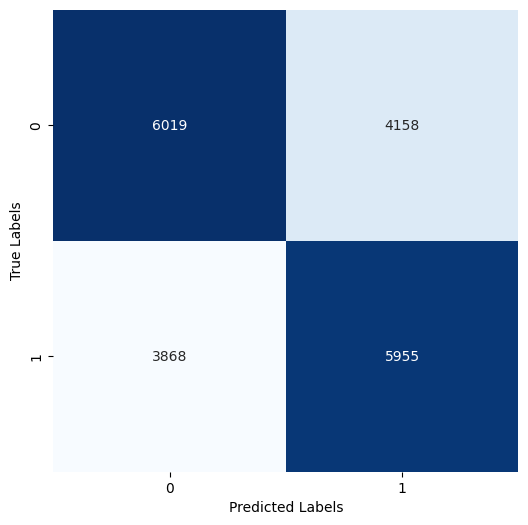


Classification Report: 
              precision    recall  f1-score   support

           0       0.61      0.59      0.60     10177
           1       0.59      0.61      0.60      9823

    accuracy                           0.60     20000
   macro avg       0.60      0.60      0.60     20000
weighted avg       0.60      0.60      0.60     20000


Model:  random_forest

Confusion Matrix: 


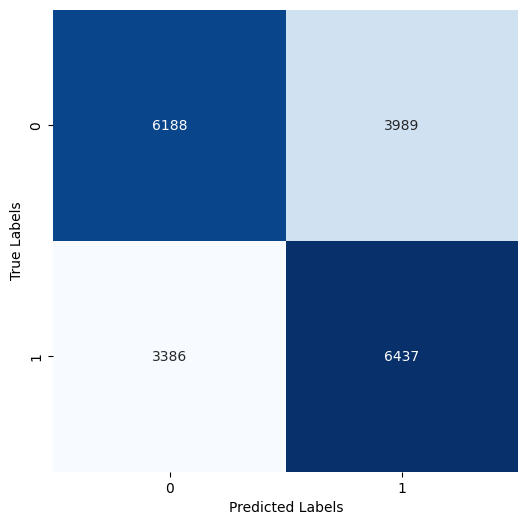


Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.61      0.63     10177
           1       0.62      0.66      0.64      9823

    accuracy                           0.63     20000
   macro avg       0.63      0.63      0.63     20000
weighted avg       0.63      0.63      0.63     20000


Model:  xgboost

Confusion Matrix: 


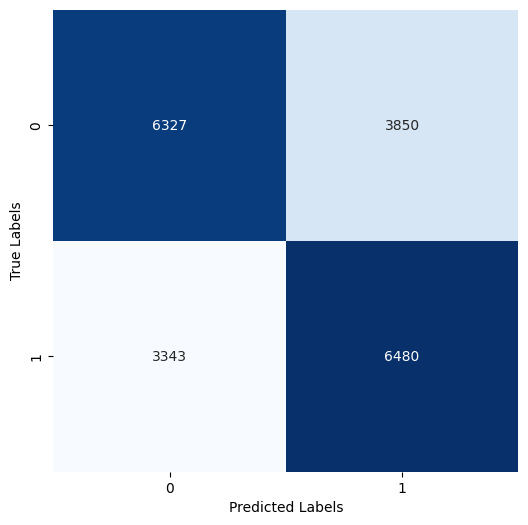


Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.62      0.64     10177
           1       0.63      0.66      0.64      9823

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



In [17]:
for model in list(model_list.keys()):

    print('\nModel: ', model)
    model_list[model].fit(X_train, y_train)
    y_pred = model_list[model].predict(X_test)

    print('\nConfusion Matrix: ')
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    print('\nClassification Report: ')
    report = classification_report(y_test, y_pred)
    print(report)
    

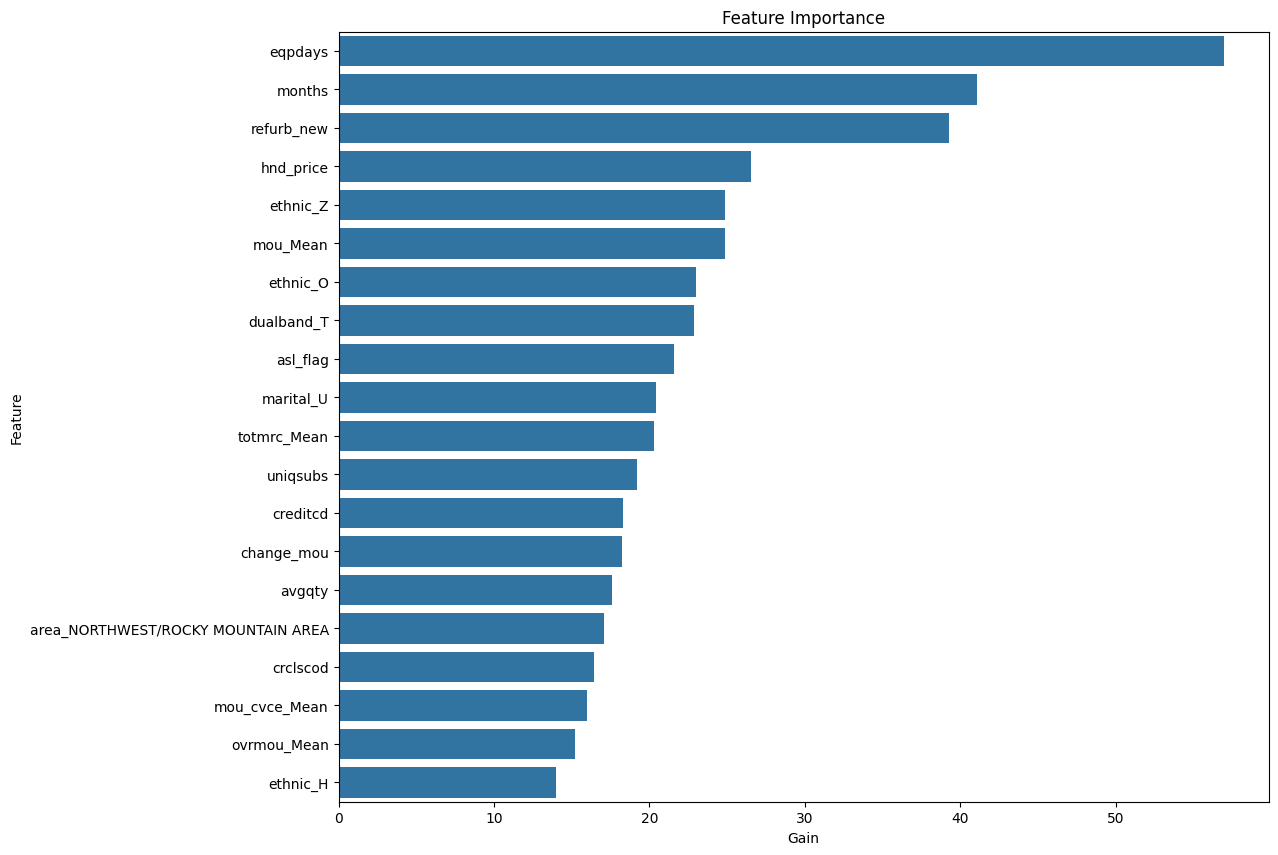

In [23]:
# feature importance for xgboost model - gain

feat_imp_gain = model_list['xgboost'].get_booster().get_score(importance_type='gain')

keys_gain = list(feat_imp_gain.keys())
vals_gain = list(feat_imp_gain.values())

feat_imp_gain_df = pd.DataFrame(data=vals_gain, index=keys_gain, columns=['score']).sort_values(by='score', ascending=False).reset_index()
feat_imp_gain_df.columns = ['feature', 'score']

plt.figure(figsize=(12, 10))

sns.barplot(x='score', y='feature', data=feat_imp_gain_df.head(20))

plt.xlabel('Gain')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

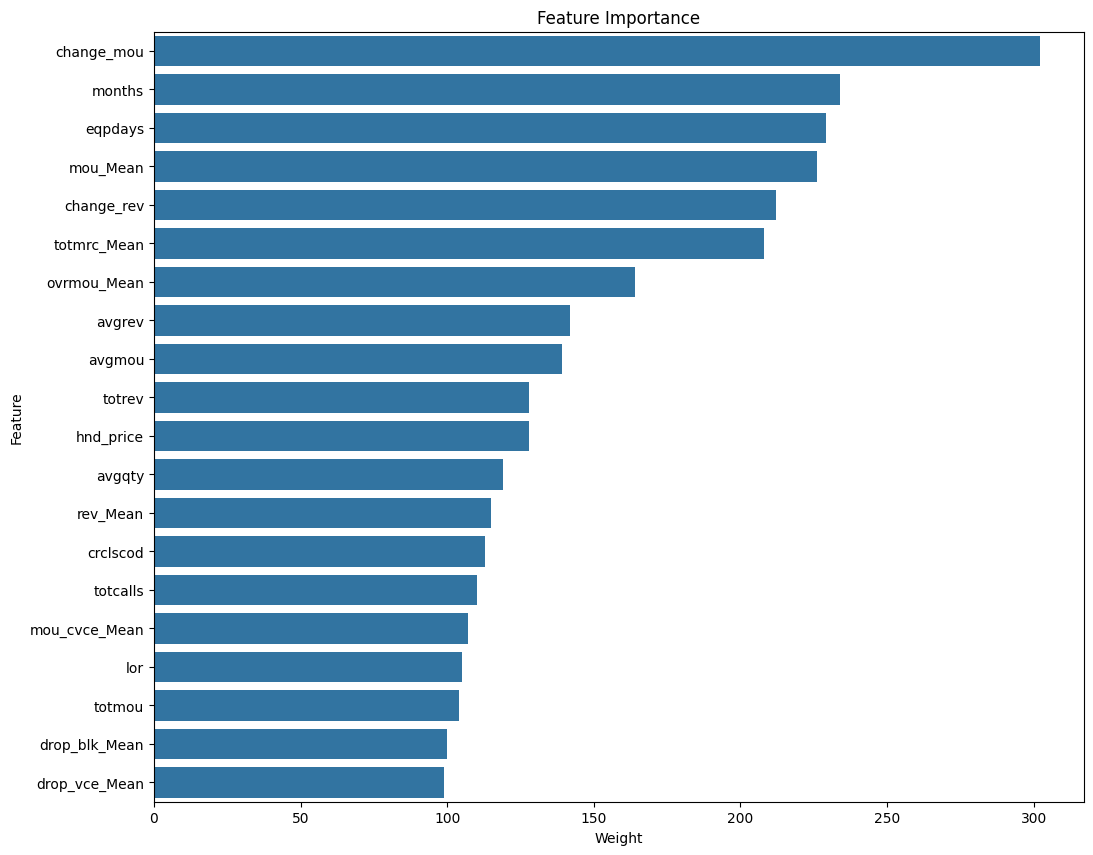

In [30]:
# feature importance for xgboost model - weight

feat_imp_weight = model_list['xgboost'].get_booster().get_score(importance_type='weight')

keys_weight = list(feat_imp_weight.keys())
vals_weight = list(feat_imp_weight.values())

feat_imp_weight_df = pd.DataFrame(data=vals_weight, index=keys_weight, columns=['score']).sort_values(by='score', ascending=False).reset_index()
feat_imp_weight_df.columns = ['feature', 'score']

plt.figure(figsize=(12, 10))

sns.barplot(x='score', y='feature', data=feat_imp_weight_df.head(20))

plt.xlabel('Weight')
plt.ylabel('Feature')
plt.title('Feature Importance')

plt.show()

In [8]:
# ensemble random forest and xgboost

rf = model_list['random_forest']
xgb = model_list['xgboost']

ensemble_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Ensemble Model Accuracy: {accuracy}')
print('Ensemble Model Classification Report: ')
print(class_report)

Ensemble Model Accuracy: 0.6409
Ensemble Model Classification Report: 
              precision    recall  f1-score   support

           0       0.66      0.61      0.64     10177
           1       0.63      0.67      0.65      9823

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



In [13]:
# creating simpler model with top features

top_cols = (feat_imp_weight_df['feature'].head(50)).to_list()

X_train_simple = (X_train[top_cols]).values
X_test_simple = (X_test[top_cols]).values

print('\nModel: ', 'xgboost')
model_list['xgboost'].fit(X_train_simple, y_train)
y_pred = model_list['xgboost'].predict(X_test_simple)

print('\nClassification Report: ')
report = classification_report(y_test, y_pred)
print(report)


Model:  xgboost

Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.62      0.63     10177
           1       0.62      0.65      0.64      9823

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



In [14]:
final_df.to_csv('../data/processed/final_data.csv', index=False)

## Appendix
- Tested SHAP plots to explain feature impact on model --> too computationally inefficient for this dataset

In [8]:
rf = model_list['random_forest']
xgb = model_list['xgboost']

shap_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft').fit(X_train, y_train)

In [23]:
import shap

sample_size = 25000
sample_indices = np.random.choice(X_train.shape[0], sample_size, replace=False)
X_train_sample = X_train.iloc[sample_indices]

explainer = shap.Explainer(shap_model.predict, X_train_sample)

In [24]:
shap_values = explainer(X_train_sample)

PermutationExplainer explainer: 25001it [11:28:33,  1.65s/it]                                


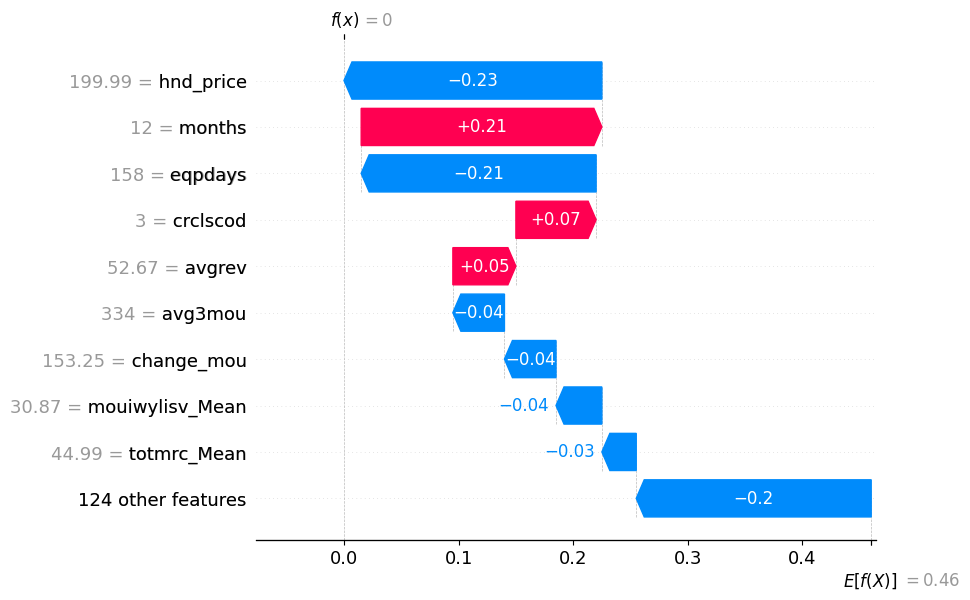

In [30]:
shap.waterfall_plot(shap_values[0])

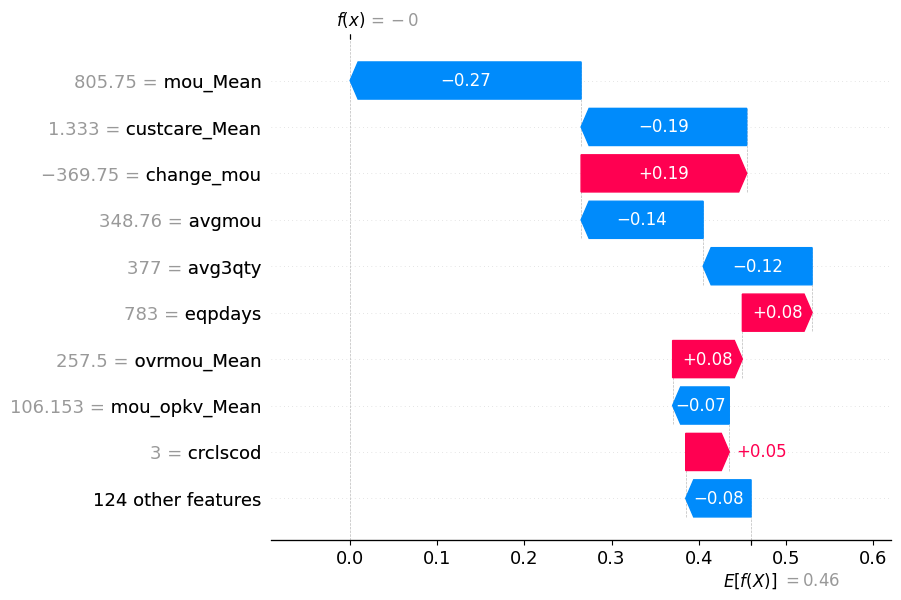

In [29]:
shap.waterfall_plot(shap_values[1])

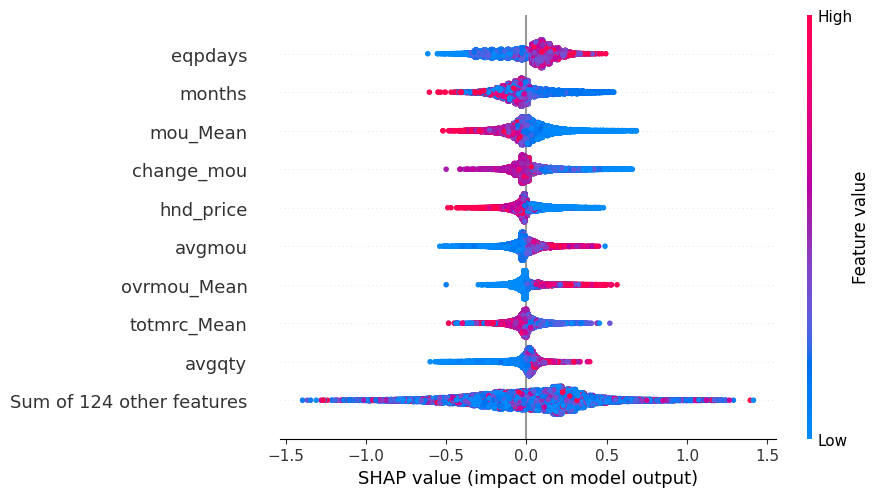

In [26]:
shap.plots.beeswarm(shap_values)

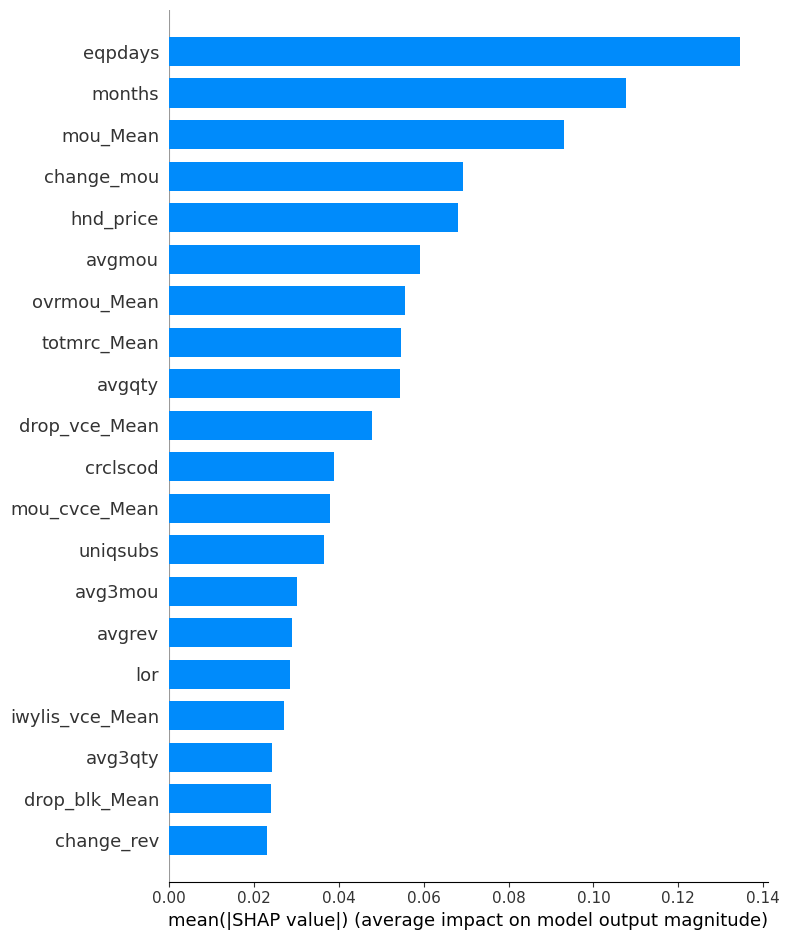

In [27]:
shap.summary_plot(shap_values, X_train_sample, plot_type="bar")